<a href="https://colab.research.google.com/github/Aravind-11/IITM_Saastra/blob/main/single_agent_continous_control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np

In [3]:
# Stable Baselines only supports tensorflow 1.x for now
%tensorflow_version 1.x
!pip install stable-baselines[mpi]==2.10.0

TensorFlow 1.x selected.
     |████████████████████████████████| 248 kB 8.0 MB/s 
  Attempting uninstall: stable-baselines
    Found existing installation: stable-baselines 2.2.1
    Uninstalling stable-baselines-2.2.1:
      Successfully uninstalled stable-baselines-2.2.1


In [59]:
import numpy as np
import gym
from random import random 
class Football:  # The class encapsulating the environment
    '''
    Actions [0 : Stand, 1 : Up, 2 : Right, 3 : Down, 4 : Left]
    These are the representing no.s for the mentioned actions
    '''

    def __init__(self, length=30, width=30, goalPositions=[15,29]):
        
        # The player start at random locations
        
        self.pA=[0,15] 
        self.pO=[6,8]
            
        
        self.h = length   # Length of the Football Pitch    
        self.w = width    # Width of the Football Pitch
        
        self.goalPositions = np.array(goalPositions)   # This means that the middle 4 positions at the right and left are the goals
        
     
        
        self.reward = 0                            # Initially the reward is 0
        
        self.observation=np.random.rand(6,)
        self.done = bool(0)                          # This stores whether the game needs to be restart with new position (in the case of a goal)

    def reset(self):
        self.done = bool(0)
        self.reward = 0
        
        self.pA = np.array([np.random.randint(self.h), np.random.randint(self.h)])
        #self.pO=[6,8]
        self.x_traj,self.y_traj=[],[]
        return np.array((*self.pA,(15-self.pA[0]),(15-self.pA[1]),*self.pO)).astype(np.float32)

    def step(self, action):
        if self.done == bool(1):
          self.reset()
        self.move(first, action)                   # We chose the first player at random
        if self.done == bool(1):
          return self.observation, self.reward, self.done
        if not done:
            self.current_player_num = (self.current_player_num + 1) % 2   
        return self.observation,self.reward, self.done,{}

    def move(self, player, action):
        opponent = 1 - player
        
        newPosition = self.pA + self.actionToMove(action)
        
        if self.ballOwner is player and self.isInGoal(*newPosition) >= 0:
            self.done = bool(1)
            return 1 - self.isInGoal(*newPosition)
        # If it's in the board
        elif self.isInBoard(*newPosition):
            self.positions[player] = newPosition
        if(self.ballOwner!=0):
          self.reward=-1
        return -1



    def isInBoard(self, x, y):
        if(x<0 or x>(30)):
          return 0
        if(y<0 or y>(30)):
          return 0 
        return 1
        

    #def choosePlayer(self):
    #    return np.random.randint(0, 2)
    def render(self,mode="human"):
        

        plt.cla()
        plt.arrow(x_start, y_start, np.cos(theta_start),
                      np.sin(theta_start), color='r', width=0.1)
        plt.arrow(x_goal, y_goal, np.cos(theta_goal),
                      np.sin(theta_goal), color='g', width=0.1)
        plot_vehicle(x, y, theta, x_traj, y_traj)

class modf_football(Football,gym.Env):
  def __init__(self, length=30, width=30, goalPositions=[29, 15]):
    super().__init__()
    self.observation_space=gym.spaces.Box(low=-30, high=30,
                                        shape=(6,), dtype=np.float32)
    self.reward=0
    self.action_space = gym.spaces.Box(
            low=-2*np.pi, high=2*np.pi, shape=(2,), dtype=np.float32
        )
    self.name='Football'
    self.current_player_num=0
    self.observation=np.random.rand(6,)
    self.pA = np.array([5,15])
    self.Kp_rho = 9
    self.dt=0.01
    self.Kp_alpha = 15
    self.Kp_beta = -3
    self.x_goal = 19
    self.y_goal = 15
    self.theta_goal = 0 
    self.theta_start = 2 * np.pi * random() - np.pi
    
    self.theta = self.theta_start

    self.x_diff = self.x_goal - self.pA[0]
    self.y_diff = self.y_goal - self.pA[1]

    self.x_traj, self.y_traj = [], []
    self.x_start=self.pA[0]
    self.y_start=self.pA[1]
    self.rho = np.hypot(self.x_diff, self.y_diff)
  #modifying the step and move function to get the updated reward system
  def step(self, action):
        
        #print('action',action)
        if self.done == bool(1):
          self.reset()
        
      
        self.move(action)                   # We chose the first player at random
        if self.done == bool(1):
          return self.observation, self.reward, self.done,{}
                   
        return self.observation,self.reward, self.done,{}
  
  def move(self, action):
        self.x_diff = self.x_goal - self.pA[0]
        self.y_diff = self.y_goal - self.pA[1]
        self.rho=np.hypot(self.x_diff,self.y_diff)
        v = self.Kp_rho * self.rho
        #v=9
        w = self.Kp_alpha * action[0] + self.Kp_beta * action[1]
        if action[0] > np.pi / 2 or action[0] < -np.pi / 2:
            v = -v

        self.theta = self.theta + w * self.dt
        x = self.pA[0] +  v* np.cos(self.theta) * self.dt
        y = self.pA[1] +  v* np.sin(self.theta) * self.dt
        newPosition = np.array([x,y])
        self.x_traj.append(x)
        self.y_traj.append(y)
        ''' if (self.pO[0]>self.pA[0]):
          self.pO[0]-=1
        elif (self.pO[0]<self.pA[0]):
          self.pO[0]+=1
        if (self.pO[1]>self.pA[1]):
          self.pO[1]-=1
        elif (self.pO[1]<self.pA[1]):
          self.pO[1]+=1
        
        self.pO[0]=max(self.pO[0],0)
        self.pO[0]=min(self.pO[0],29)
        self.pO[1]=max(self.pO[1],0)
        self.pO[1]=min(self.pO[1],29)
        '''

        if self.isInGoal(*newPosition) >= 0:
            
            self.done = bool(1)
            return 1 - self.isInGoal(*newPosition)
        # If it's in the board
        if self.isInBoard(*newPosition):
               
            self.reward = -0.1 * ((abs((self.pA[0]-self.goalPositions[0])))+(abs(self.pA[1]-self.goalPositions[1]))) +0*(abs(newPosition[0]-self.pO[0])+abs(newPosition[1]-self.pO[1]))
            self.pA = newPosition

        
        self.observation=np.array((*self.pA,(15-self.pA[0]),(15-self.pA[1]),*self.pO)).astype(np.float32)
        return -1
  def isInGoal(self, x, y):
     x_diff = self.x_goal - x
     y_diff = self.y_goal - y
     rho = np.hypot(x_diff, y_diff)
     if(rho<0.001):
       self.done=bool(1)
       self.reward=20  
     return -1
  def transformation_matrix(self,x, y, theta):
    return np.array([
        [np.cos(theta), -np.sin(theta), x],
        [np.sin(theta), np.cos(theta), y],
        [0, 0, 1]
    ])
  def plot_vehicle(self,x, y, theta, x_traj, y_traj):  # pragma: no cover
    # Corners of triangular vehicle when pointing to the right (0 radians)
    p1_i = np.array([0.5, 0, 1]).T
    p2_i = np.array([-0.5, 0.25, 1]).T
    p3_i = np.array([-0.5, -0.25, 1]).T

    T = self.transformation_matrix(x, y, theta)
    p1 = np.matmul(T, p1_i)
    p2 = np.matmul(T, p2_i)
    p3 = np.matmul(T, p3_i)
    
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], 'k-')
    plt.plot([p2[0], p3[0]], [p2[1], p3[1]], 'k-')
    plt.plot([p3[0], p1[0]], [p3[1], p1[1]], 'k-')
    plt.style.use('seaborn')
    plt.scatter([5,10,15],[17,10,12],s=100,c='green',edgecolor='black',linewidth=1,alpha=0.75) 
    plt.style.use('seaborn')
    plt.scatter([18],[15],s=100,c='red',edgecolor='black',linewidth=2,alpha=0.75)   
    plt.plot(x_traj, y_traj, 'b--')
    #circle1 = plt.Circle((0, 0), 0.2, color='r')
    #fig, ax = plt.subplots()
    
    # for stopping simulation with the esc key.
    plt.gcf().canvas.mpl_connect('key_release_event',
            lambda event: [exit(0) if event.key == 'escape' else None])
    
    plt.xlim(0, 20)
    plt.ylim(0, 20)
    
    plt.pause(self.dt)
  def render(self,mode="human"):
        

        plt.cla()
        plt.arrow(self.x_start, self.y_start, np.cos(self.theta_start),
                      np.sin(self.theta_start), color='r', width=0.1)
        plt.arrow(self.x_goal, self.y_goal, np.cos(self.theta_goal),
                      np.sin(self.theta_goal), color='g', width=0.1)
        self.plot_vehicle(self.pA[0], self.pA[1], self.theta, self.x_traj, self.y_traj)
  def seed():
      return 0 
  def metadata(x):
      return 0 
  def legal_actions(self):
    return gym.spaces.Discrete(5)
  def close(self):
    pass

env=modf_football(Football,gym.Env)

In [55]:
from stable_baselines.common.env_checker import check_env

check_env(env, warn=True)

/usr/local/lib/python3.7/dist-packages/stable_baselines/common/env_checker.py:210: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf https://stable-baselines.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn("We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) "


In [9]:
from stable_baselines import DQN, PPO2, A2C, ACKTR
from stable_baselines.common.cmd_util import make_vec_env

env = make_vec_env(lambda: env, n_envs=1)

In [60]:
model = PPO2('MlpPolicy', env, verbose=1).learn(10000)

Wrapping the env in a DummyVecEnv.
-------------------------------------
| approxkl           | 0.0018650712 |
| clipfrac           | 0.005859375  |
| explained_variance | -0.00524     |
| fps                | 342          |
| n_updates          | 1            |
| policy_entropy     | 2.837965     |
| policy_loss        | -0.005048877 |
| serial_timesteps   | 128          |
| time_elapsed       | 1.6e-05      |
| total_timesteps    | 128          |
| value_loss         | 9.191136     |
-------------------------------------
--------------------------------------
| approxkl           | 0.00038402347 |
| clipfrac           | 0.0           |
| explained_variance | -0.0511       |
| fps                | 848           |
| n_updates          | 2             |
| policy_entropy     | 2.8375373     |
| policy_loss        | 0.00048652804 |
| serial_timesteps   | 256           |
| time_elapsed       | 0.375         |
| total_timesteps    | 256           |
| value_loss         | 112.891846    |
---

Step 1
Action:  [ 0.11082104 -0.01288705]
obs= [16.180765   5.413828  -1.1807648  9.586172   6.         8.       ] reward= -2.6 done= False


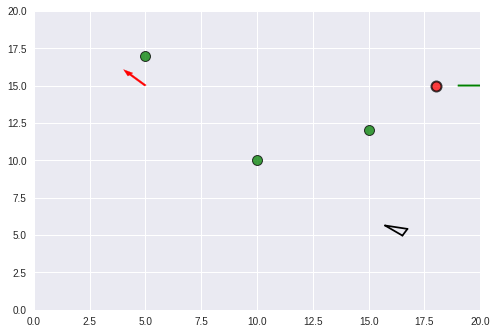

Step 2
Action:  [ 0.1264627  -0.05955544]
obs= [15.369828   5.8025537 -0.3698278  9.197446   6.         8.       ] reward= -2.4766936716711676 done= False


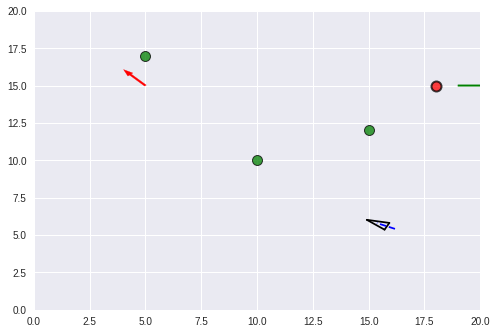

Step 3
Action:  [ 0.14143611 -0.10561994]
obs= [14.5582075   6.167546    0.44179246  8.832455    6.          8.        ] reward= -2.3567273963735995 done= False


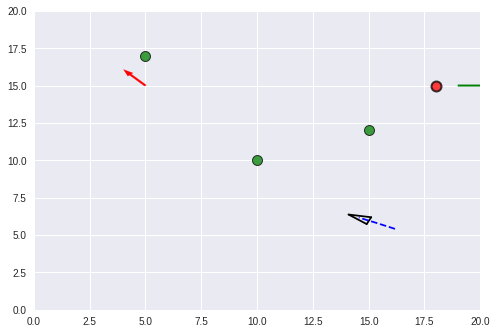

Step 4
Action:  [ 0.15739498 -0.15466554]
obs= [13.736725   6.5094156  1.2632748  8.490584   6.         8.       ] reward= -2.327424685771915 done= False


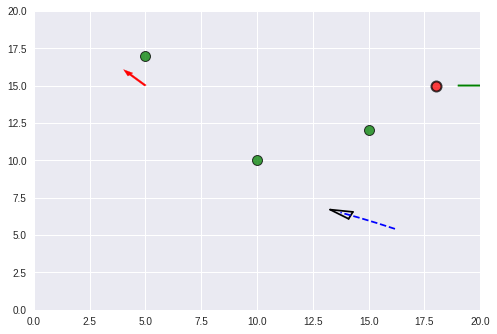

Step 5
Action:  [ 0.17534585 -0.2086526 ]
obs= [12.895865   6.8276467  2.1041343  8.172353   6.         8.       ] reward= -2.3753859012411938 done= False


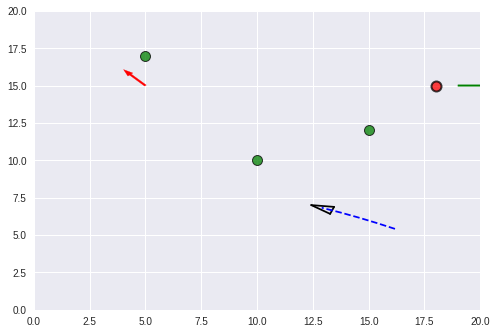

Step 6
Action:  [ 0.19229124 -0.26208982]
obs= [12.025917  7.120865  2.974083  7.879135  6.        8.      ] reward= -2.427648747318618 done= False


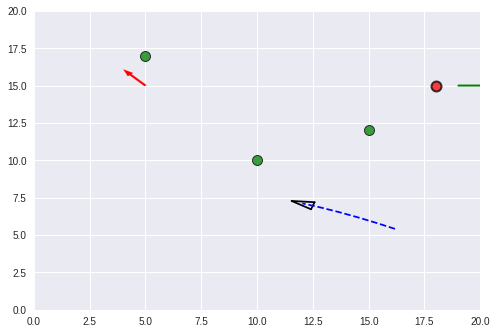

Step 7
Action:  [ 0.20532839 -0.30910057]
obs= [11.117117   7.387142   3.8828828  7.612858   6.         8.       ] reward= -2.485321812151897 done= False


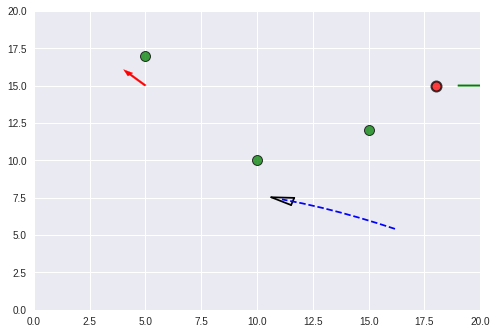

Step 8
Action:  [ 0.21552427 -0.35160822]
obs= [10.159598  7.62364   4.840401  7.37636   6.        8.      ] reward= -2.549574069312733 done= False


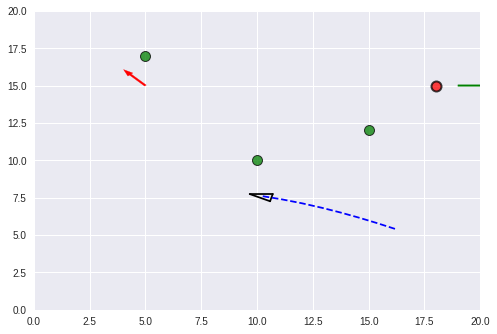

Step 9
Action:  [ 0.22403428 -0.39291364]
obs= [9.143366  7.8262067 5.8566346 7.1737933 6.        8.       ] reward= -2.6216760944001836 done= False


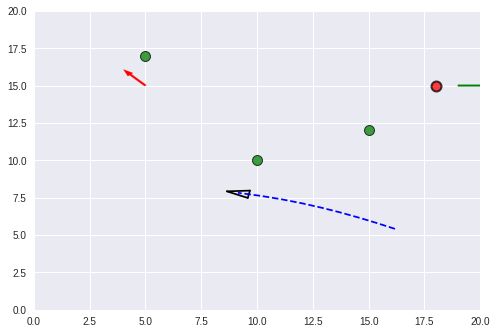

Step 10
Action:  [ 0.23087813 -0.4340072 ]
obs= [8.058363 7.98919  6.941637 7.01081  6.       8.      ] reward= -2.703042776667236 done= False


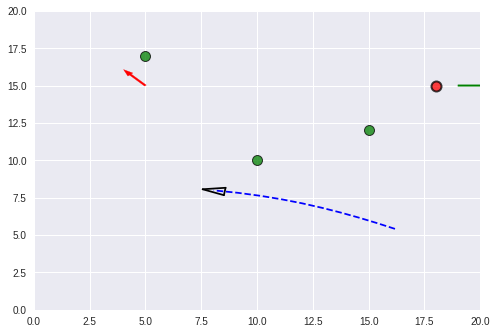

Step 11
Action:  [ 0.23467667 -0.47050464]
obs= [6.8946276 8.105699  8.105372  6.8943014 6.        8.       ] reward= -2.795244689497692 done= False


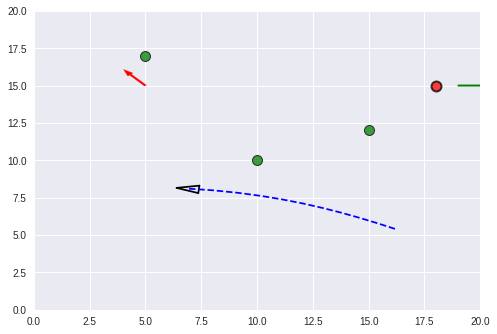

Step 12
Action:  [ 0.23478115 -0.49623626]
obs= [5.642389  8.16796   9.357612  6.8320403 6.        8.       ] reward= -2.899967388102537 done= False


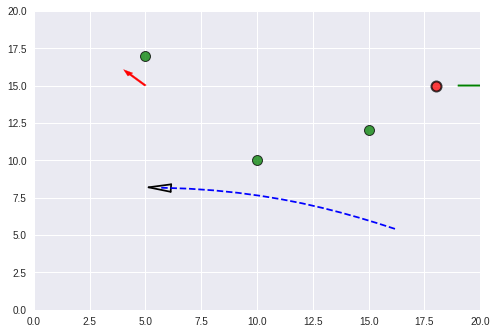

Step 13
Action:  [ 0.23331435 -0.51207453]
obs= [ 4.2920814  8.167041  10.707918   6.8329587  6.         8.       ] reward= -3.0189651426589155 done= False


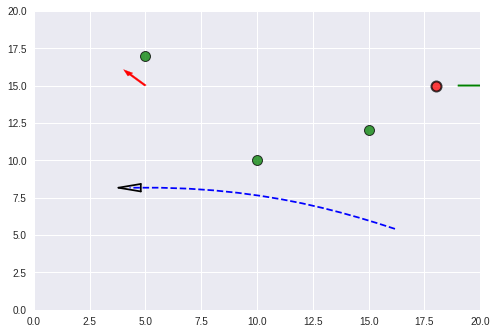

Step 14
Action:  [ 0.2325381  -0.52365714]
obs= [ 2.834411  8.092239 12.165589  6.90776   6.        8.      ] reward= -3.154087735446153 done= False


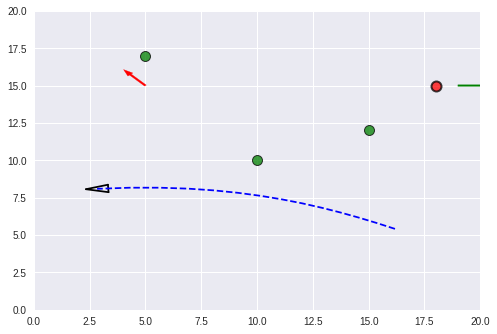

Step 15
Action:  [ 0.23326   -0.5346818]
obs= [ 1.2605158  7.930666  13.739484   7.069334   6.         8.       ] reward= -3.307334933323461 done= False


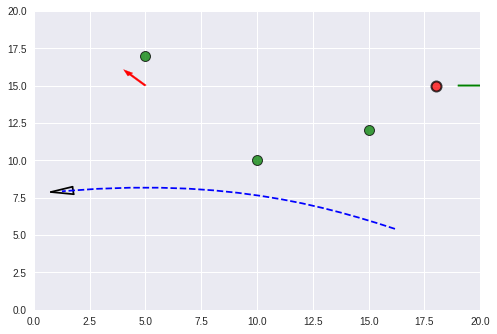

Step 16
Action:  [ 0.23287798 -0.5371384 ]
obs= [ 1.2605158  7.930666  13.739484   7.069334   6.         8.       ] reward= -3.307334933323461 done= False


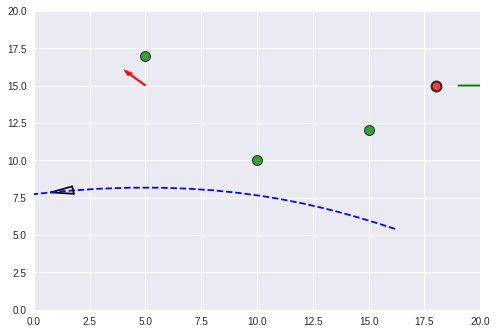

Step 17
Action:  [ 0.23287798 -0.5371384 ]
obs= [ 1.2605158  7.930666  13.739484   7.069334   6.         8.       ] reward= -3.307334933323461 done= False


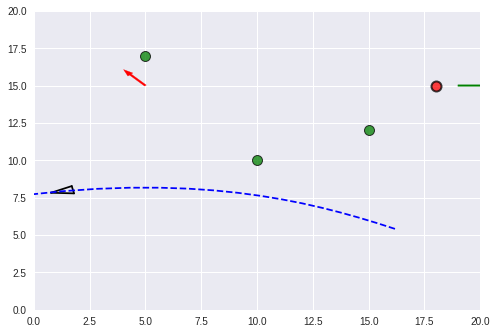

Step 18
Action:  [ 0.23287798 -0.5371384 ]
obs= [ 1.2605158  7.930666  13.739484   7.069334   6.         8.       ] reward= -3.307334933323461 done= False


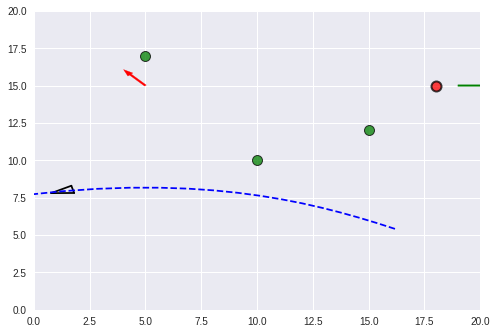

Step 19
Action:  [ 0.23287798 -0.5371384 ]
obs= [ 1.2605158  7.930666  13.739484   7.069334   6.         8.       ] reward= -3.307334933323461 done= False


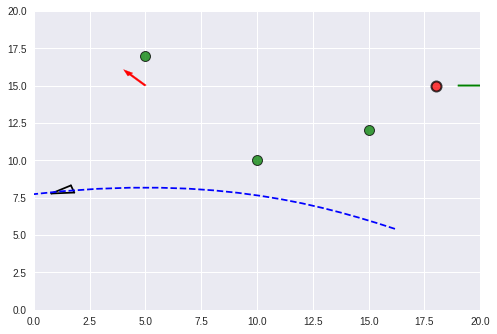

Step 20
Action:  [ 0.23287798 -0.5371384 ]
obs= [ 1.2605158  7.930666  13.739484   7.069334   6.         8.       ] reward= -3.307334933323461 done= False


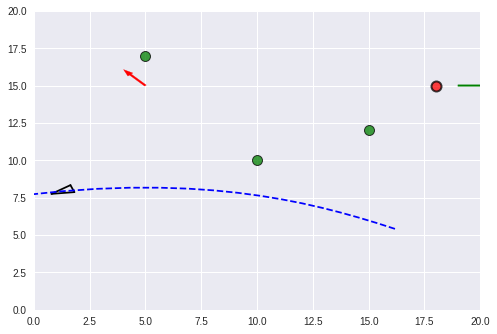

Step 21
Action:  [ 0.23287798 -0.5371384 ]
obs= [ 1.2605158  7.930666  13.739484   7.069334   6.         8.       ] reward= -3.307334933323461 done= False


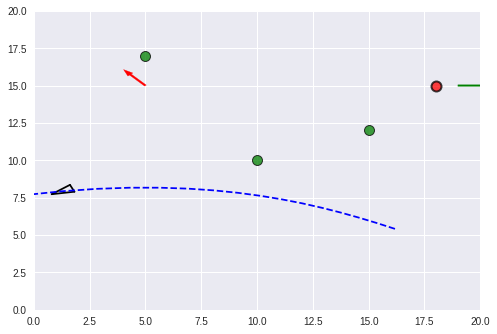

Step 22
Action:  [ 0.23287798 -0.5371384 ]
obs= [ 1.2605158  7.930666  13.739484   7.069334   6.         8.       ] reward= -3.307334933323461 done= False


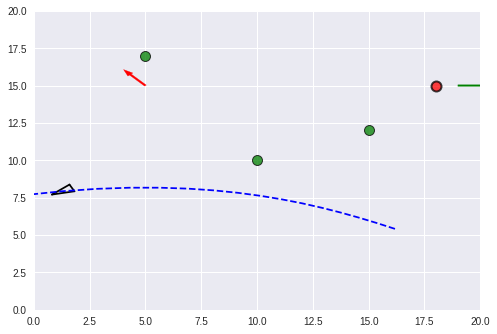

Step 23
Action:  [ 0.23287798 -0.5371384 ]
obs= [ 1.2605158  7.930666  13.739484   7.069334   6.         8.       ] reward= -3.307334933323461 done= False


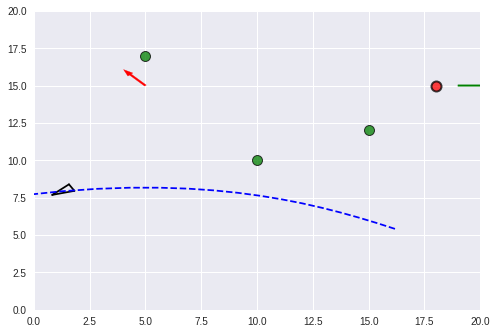

Step 24
Action:  [ 0.23287798 -0.5371384 ]
obs= [ 1.2605158  7.930666  13.739484   7.069334   6.         8.       ] reward= -3.307334933323461 done= False


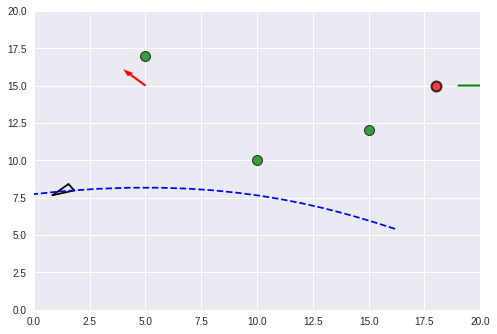

Step 25
Action:  [ 0.23287798 -0.5371384 ]
obs= [ 1.2605158  7.930666  13.739484   7.069334   6.         8.       ] reward= -3.307334933323461 done= False


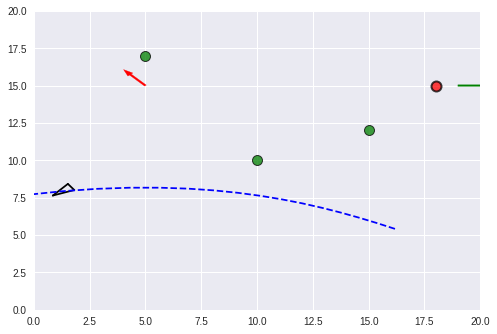

Step 26
Action:  [ 0.23287798 -0.5371384 ]
obs= [ 1.2605158  7.930666  13.739484   7.069334   6.         8.       ] reward= -3.307334933323461 done= False


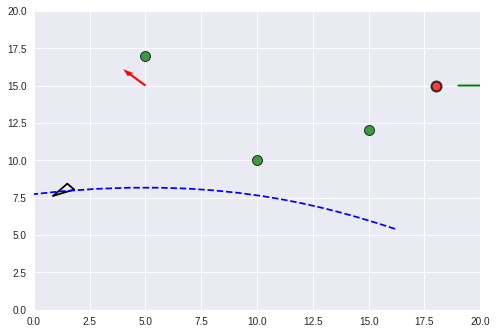

Step 27
Action:  [ 0.23287798 -0.5371384 ]
obs= [ 1.2605158  7.930666  13.739484   7.069334   6.         8.       ] reward= -3.307334933323461 done= False


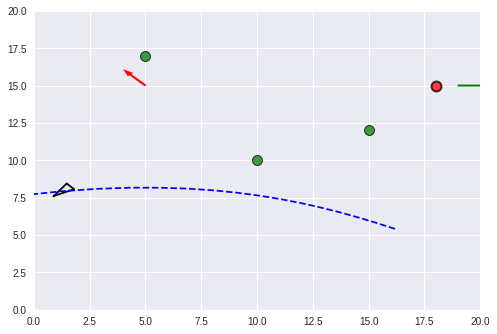

Step 28
Action:  [ 0.23287798 -0.5371384 ]
obs= [ 0.02177359  6.739321   14.978227    8.260679    6.          8.        ] reward= -3.4808818183111896 done= False


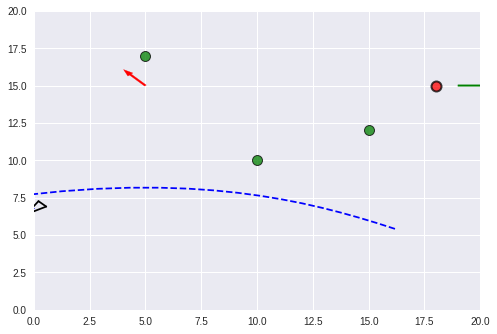

Step 29
Action:  [ 0.22989468 -0.5205915 ]
obs= [ 0.02177359  6.739321   14.978227    8.260679    6.          8.        ] reward= -3.4808818183111896 done= False


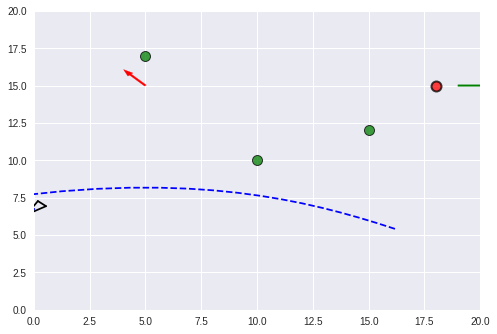

Step 30
Action:  [ 0.22989468 -0.5205915 ]
obs= [ 0.02177359  6.739321   14.978227    8.260679    6.          8.        ] reward= -3.4808818183111896 done= False


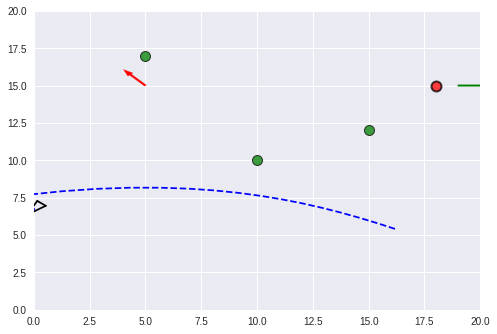

Step 31
Action:  [ 0.22989468 -0.5205915 ]
obs= [ 0.02177359  6.739321   14.978227    8.260679    6.          8.        ] reward= -3.4808818183111896 done= False


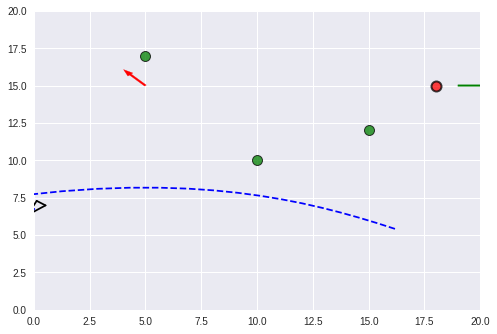

Step 32
Action:  [ 0.22989468 -0.5205915 ]
obs= [ 0.02177359  6.739321   14.978227    8.260679    6.          8.        ] reward= -3.4808818183111896 done= False


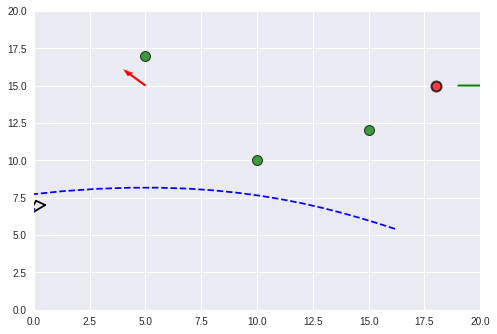

Step 33
Action:  [ 0.22989468 -0.5205915 ]
obs= [ 0.02177359  6.739321   14.978227    8.260679    6.          8.        ] reward= -3.4808818183111896 done= False


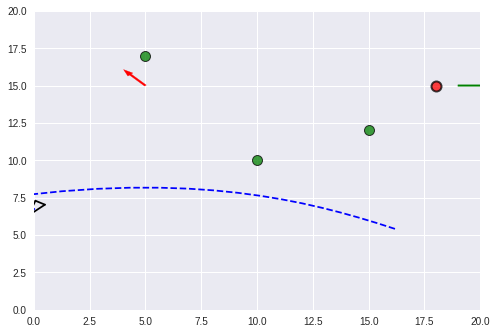

Step 34
Action:  [ 0.22989468 -0.5205915 ]
obs= [ 0.02177359  6.739321   14.978227    8.260679    6.          8.        ] reward= -3.4808818183111896 done= False


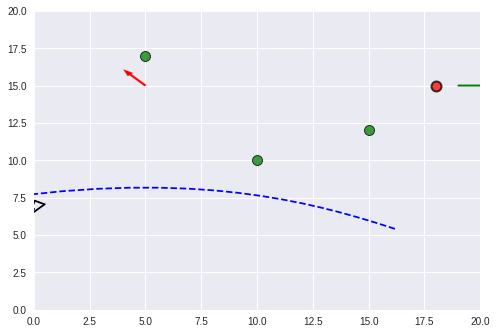

Step 35
Action:  [ 0.22989468 -0.5205915 ]
obs= [ 0.02177359  6.739321   14.978227    8.260679    6.          8.        ] reward= -3.4808818183111896 done= False


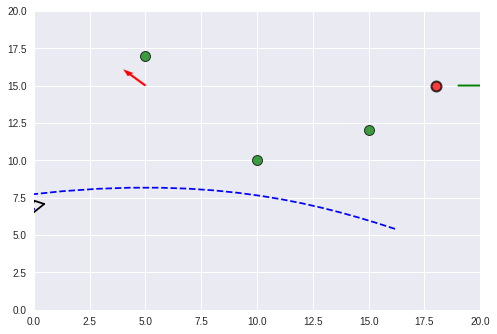

Step 36
Action:  [ 0.22989468 -0.5205915 ]
obs= [ 0.02177359  6.739321   14.978227    8.260679    6.          8.        ] reward= -3.4808818183111896 done= False


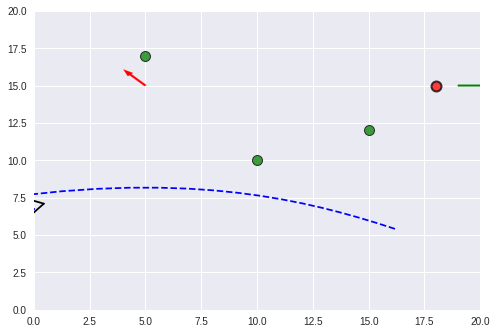

Step 37
Action:  [ 0.22989468 -0.5205915 ]
obs= [ 0.02177359  6.739321   14.978227    8.260679    6.          8.        ] reward= -3.4808818183111896 done= False


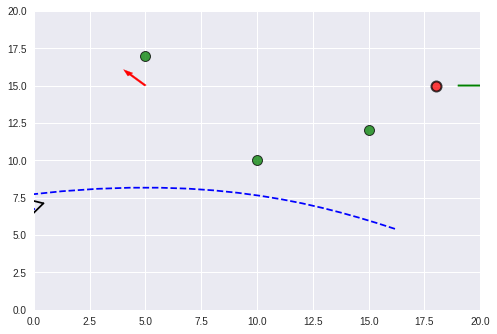

Step 38
Action:  [ 0.22989468 -0.5205915 ]
obs= [ 0.02177359  6.739321   14.978227    8.260679    6.          8.        ] reward= -3.4808818183111896 done= False


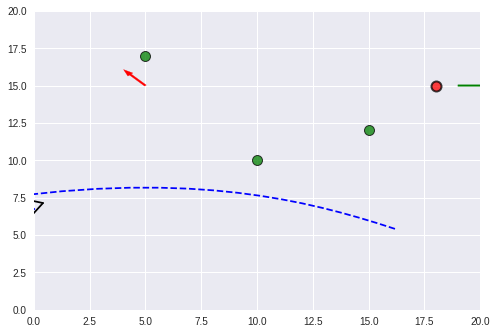

Step 39
Action:  [ 0.22989468 -0.5205915 ]
obs= [ 0.02177359  6.739321   14.978227    8.260679    6.          8.        ] reward= -3.4808818183111896 done= False


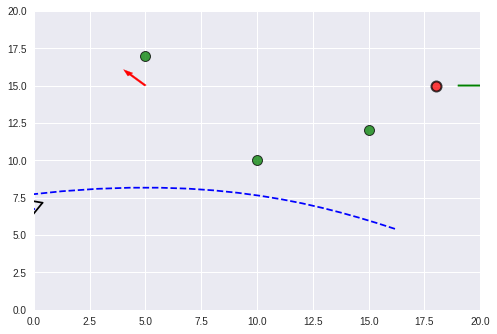

Step 40
Action:  [ 0.22989468 -0.5205915 ]
obs= [ 0.02177359  6.739321   14.978227    8.260679    6.          8.        ] reward= -3.4808818183111896 done= False


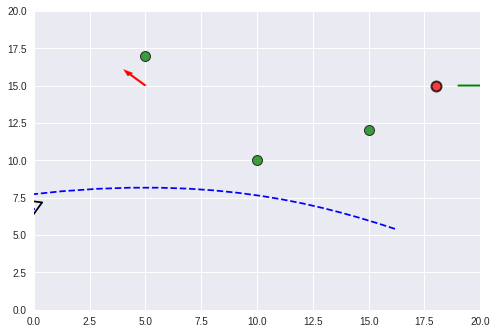

Step 41
Action:  [ 0.22989468 -0.5205915 ]
obs= [ 0.02177359  6.739321   14.978227    8.260679    6.          8.        ] reward= -3.4808818183111896 done= False


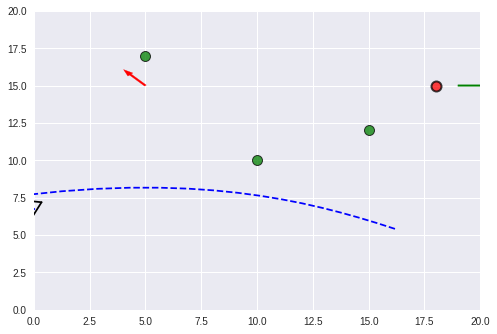

Step 42
Action:  [ 0.22989468 -0.5205915 ]
obs= [ 0.02177359  6.739321   14.978227    8.260679    6.          8.        ] reward= -3.4808818183111896 done= False


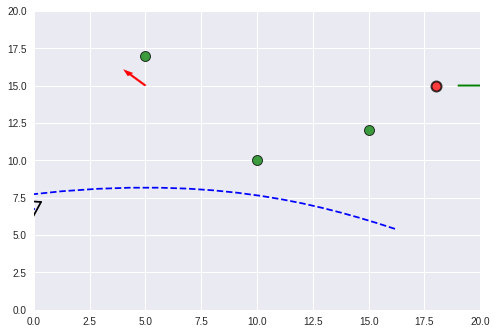

Step 43
Action:  [ 0.22989468 -0.5205915 ]
obs= [ 0.02177359  6.739321   14.978227    8.260679    6.          8.        ] reward= -3.4808818183111896 done= False


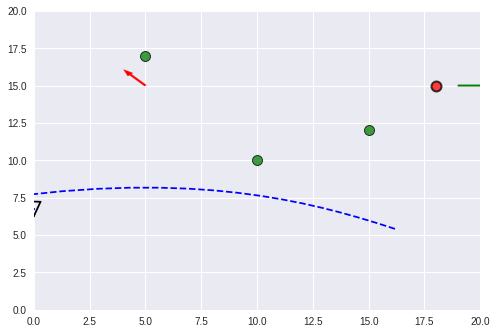

Step 44
Action:  [ 0.22989468 -0.5205915 ]
obs= [ 0.01568414  4.876501   14.984316   10.123499    6.          8.        ] reward= -3.7238905211759956 done= False


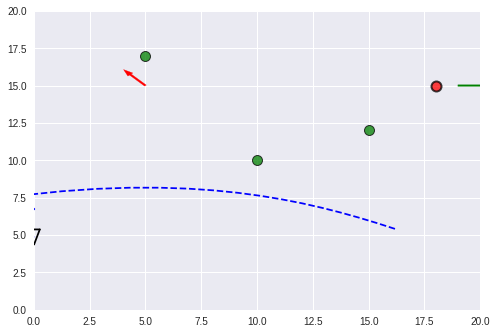

Step 45
Action:  [ 0.22622553 -0.4971155 ]
obs= [ 0.1039087  2.942174  14.896091  12.057826   6.         8.       ] reward= -3.9107814906221883 done= False


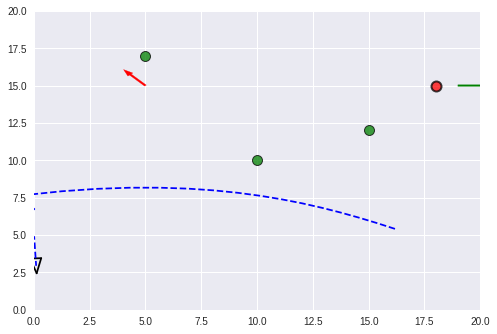

Step 46
Action:  [ 0.22628605 -0.47827232]
obs= [ 0.29300222  0.9336629  14.706998   14.066338    6.          8.        ] reward= -4.095391742184243 done= False


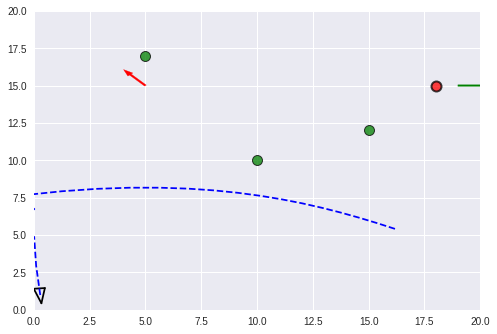

Step 47
Action:  [ 0.23046662 -0.46212858]
obs= [ 0.29300222  0.9336629  14.706998   14.066338    6.          8.        ] reward= -4.095391742184243 done= False


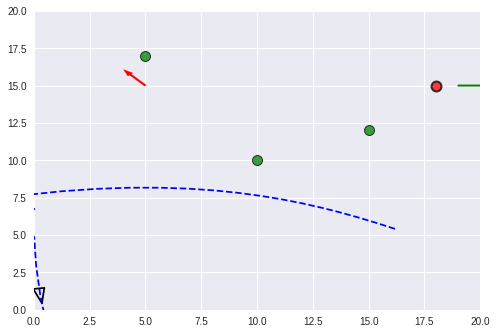

Step 48
Action:  [ 0.23046662 -0.46212858]
obs= [ 0.29300222  0.9336629  14.706998   14.066338    6.          8.        ] reward= -4.095391742184243 done= False


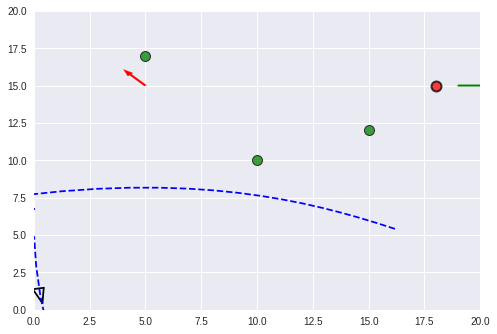

Step 49
Action:  [ 0.23046662 -0.46212858]
obs= [ 0.29300222  0.9336629  14.706998   14.066338    6.          8.        ] reward= -4.095391742184243 done= False


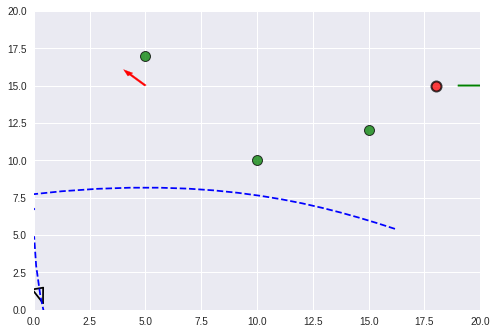

Step 50
Action:  [ 0.23046662 -0.46212858]
obs= [ 0.29300222  0.9336629  14.706998   14.066338    6.          8.        ] reward= -4.095391742184243 done= False


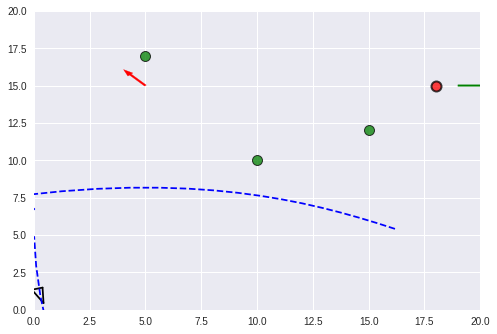

Step 51
Action:  [ 0.23046662 -0.46212858]
obs= [ 0.29300222  0.9336629  14.706998   14.066338    6.          8.        ] reward= -4.095391742184243 done= False


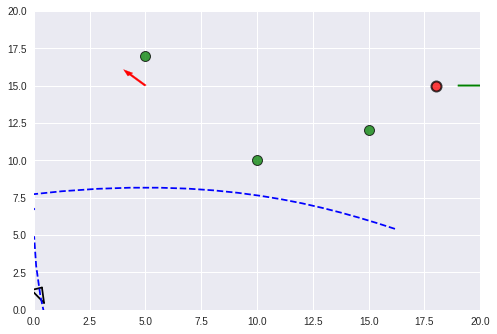

Step 52
Action:  [ 0.23046662 -0.46212858]
obs= [ 0.29300222  0.9336629  14.706998   14.066338    6.          8.        ] reward= -4.095391742184243 done= False


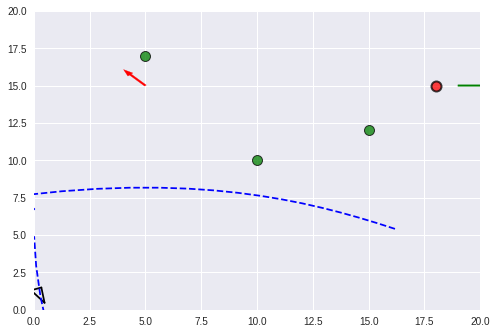

Step 53
Action:  [ 0.23046662 -0.46212858]
obs= [ 0.29300222  0.9336629  14.706998   14.066338    6.          8.        ] reward= -4.095391742184243 done= False


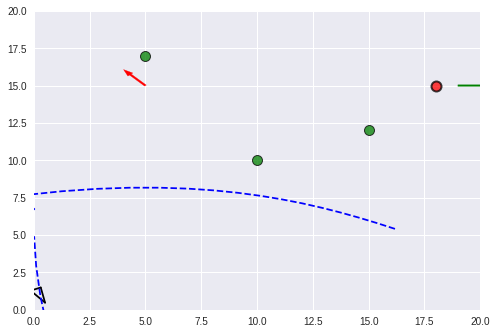

Step 54
Action:  [ 0.23046662 -0.46212858]
obs= [ 0.29300222  0.9336629  14.706998   14.066338    6.          8.        ] reward= -4.095391742184243 done= False


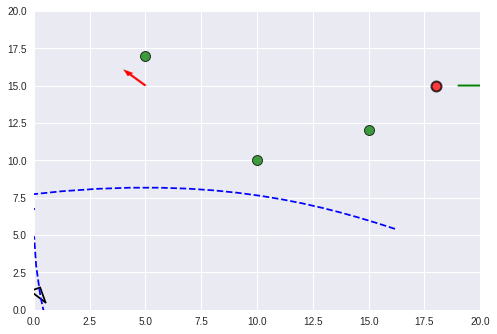

Step 55
Action:  [ 0.23046662 -0.46212858]
obs= [ 0.29300222  0.9336629  14.706998   14.066338    6.          8.        ] reward= -4.095391742184243 done= False


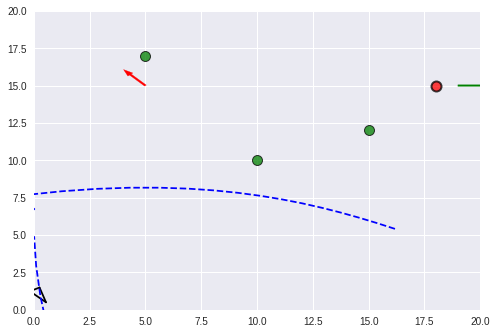

Step 56
Action:  [ 0.23046662 -0.46212858]
obs= [ 0.29300222  0.9336629  14.706998   14.066338    6.          8.        ] reward= -4.095391742184243 done= False


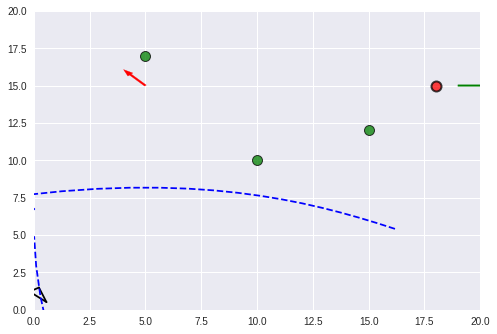

Step 57
Action:  [ 0.23046662 -0.46212858]
obs= [ 0.29300222  0.9336629  14.706998   14.066338    6.          8.        ] reward= -4.095391742184243 done= False


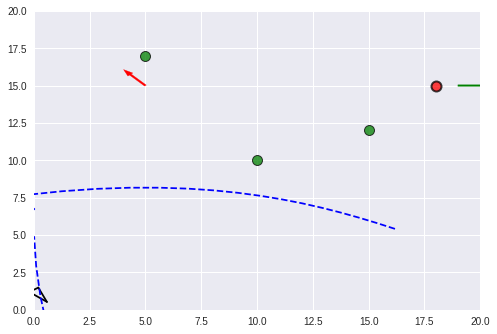

Step 58
Action:  [ 0.23046662 -0.46212858]
obs= [ 0.29300222  0.9336629  14.706998   14.066338    6.          8.        ] reward= -4.095391742184243 done= False


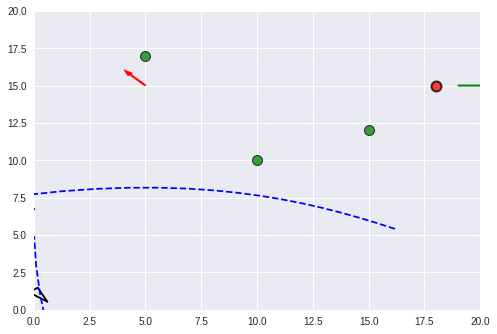

Step 59
Action:  [ 0.23046662 -0.46212858]
obs= [ 0.29300222  0.9336629  14.706998   14.066338    6.          8.        ] reward= -4.095391742184243 done= False


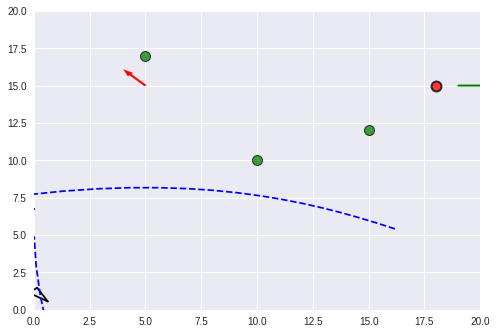

Step 60
Action:  [ 0.23046662 -0.46212858]
obs= [ 0.29300222  0.9336629  14.706998   14.066338    6.          8.        ] reward= -4.095391742184243 done= False


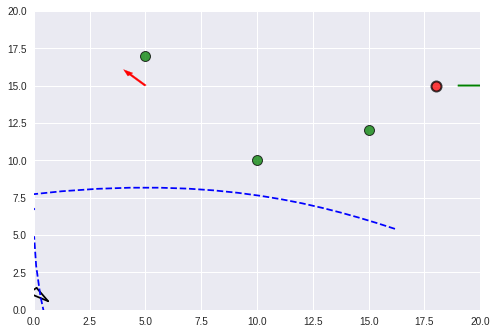

Step 61
Action:  [ 0.23046662 -0.46212858]
obs= [ 0.29300222  0.9336629  14.706998   14.066338    6.          8.        ] reward= -4.095391742184243 done= False


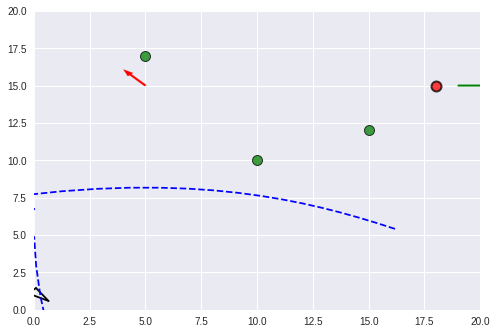

Step 62
Action:  [ 0.23046662 -0.46212858]
obs= [ 0.29300222  0.9336629  14.706998   14.066338    6.          8.        ] reward= -4.095391742184243 done= False


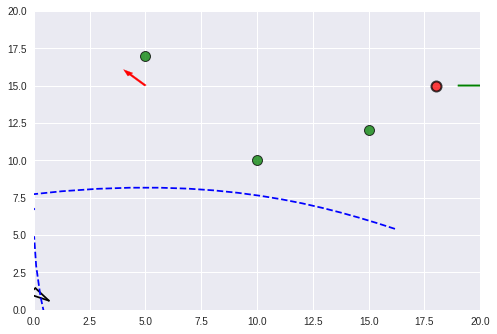

Step 63
Action:  [ 0.23046662 -0.46212858]
obs= [ 0.29300222  0.9336629  14.706998   14.066338    6.          8.        ] reward= -4.095391742184243 done= False


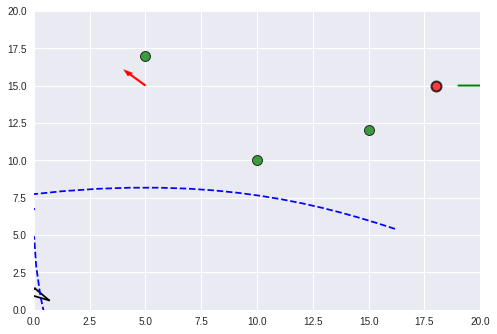

Step 64
Action:  [ 0.23046662 -0.46212858]
obs= [ 0.29300222  0.9336629  14.706998   14.066338    6.          8.        ] reward= -4.095391742184243 done= False


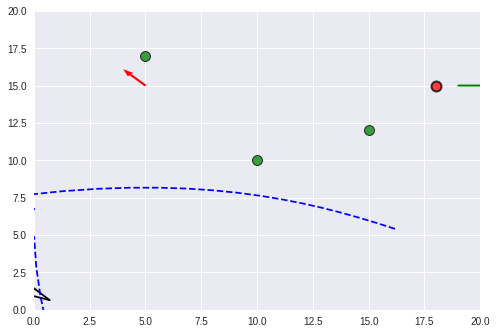

Step 65
Action:  [ 0.23046662 -0.46212858]
obs= [ 0.29300222  0.9336629  14.706998   14.066338    6.          8.        ] reward= -4.095391742184243 done= False


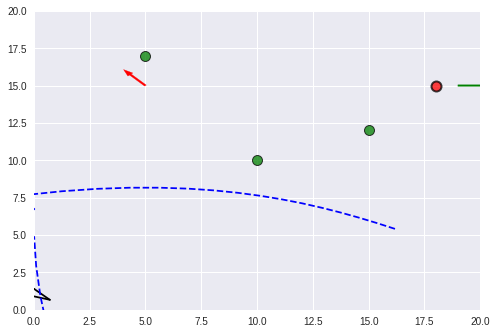

Step 66
Action:  [ 0.23046662 -0.46212858]
obs= [ 0.29300222  0.9336629  14.706998   14.066338    6.          8.        ] reward= -4.095391742184243 done= False


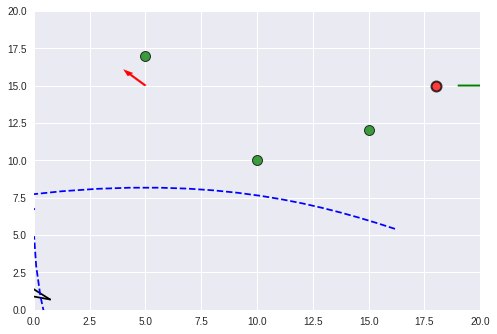

Step 67
Action:  [ 0.23046662 -0.46212858]
obs= [ 0.29300222  0.9336629  14.706998   14.066338    6.          8.        ] reward= -4.095391742184243 done= False


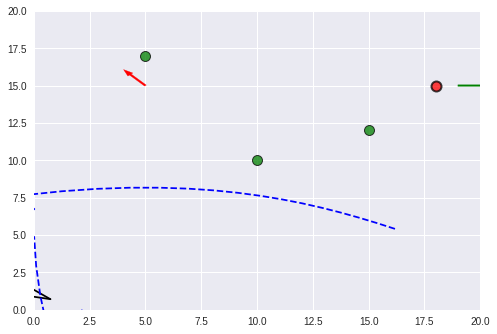

Step 68
Action:  [ 0.23046662 -0.46212858]
obs= [ 2.2237434   0.09132781 12.776257   14.908672    6.          8.        ] reward= -4.277333490773692 done= False


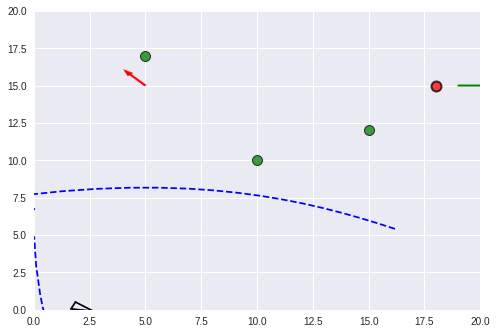

Step 69
Action:  [ 0.23533942 -0.45524937]
obs= [ 2.2237434   0.09132781 12.776257   14.908672    6.          8.        ] reward= -4.277333490773692 done= False


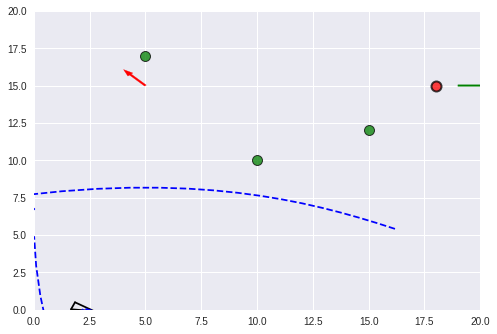

Step 70
Action:  [ 0.23533942 -0.45524937]
obs= [ 2.2237434   0.09132781 12.776257   14.908672    6.          8.        ] reward= -4.277333490773692 done= False


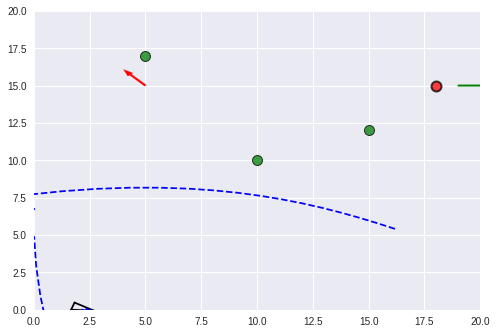

Step 71
Action:  [ 0.23533942 -0.45524937]
obs= [ 2.2237434   0.09132781 12.776257   14.908672    6.          8.        ] reward= -4.277333490773692 done= False


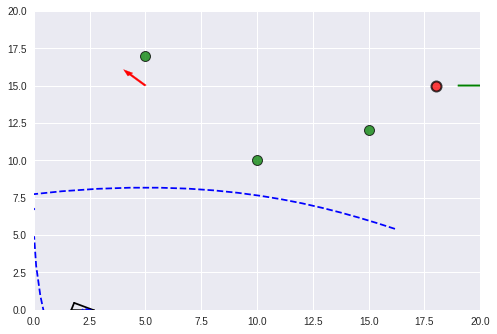

Step 72
Action:  [ 0.23533942 -0.45524937]
obs= [ 2.2237434   0.09132781 12.776257   14.908672    6.          8.        ] reward= -4.277333490773692 done= False


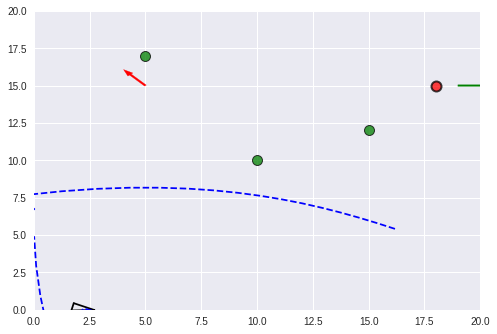

Step 73
Action:  [ 0.23533942 -0.45524937]
obs= [ 2.2237434   0.09132781 12.776257   14.908672    6.          8.        ] reward= -4.277333490773692 done= False


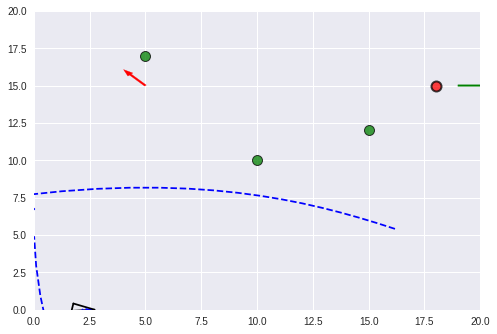

Step 74
Action:  [ 0.23533942 -0.45524937]
obs= [ 2.2237434   0.09132781 12.776257   14.908672    6.          8.        ] reward= -4.277333490773692 done= False


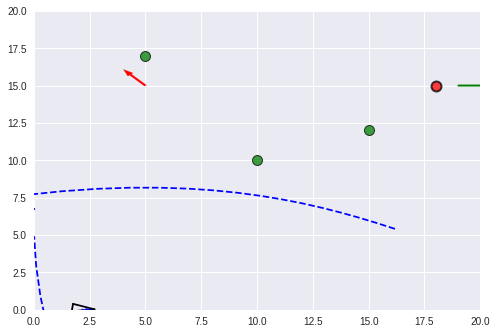

Step 75
Action:  [ 0.23533942 -0.45524937]
obs= [ 2.2237434   0.09132781 12.776257   14.908672    6.          8.        ] reward= -4.277333490773692 done= False


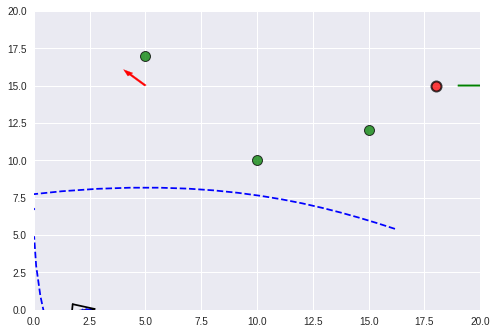

Step 76
Action:  [ 0.23533942 -0.45524937]
obs= [ 4.243267    0.05150767 10.756733   14.948492    6.          8.        ] reward= -4.168492870536674 done= False


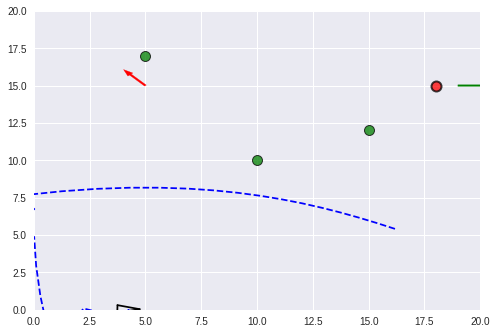

Step 77
Action:  [ 0.23238538 -0.4337172 ]
obs= [ 6.132986    0.10472544  8.867014   14.895274    6.          8.        ] reward= -3.97052251821619 done= False


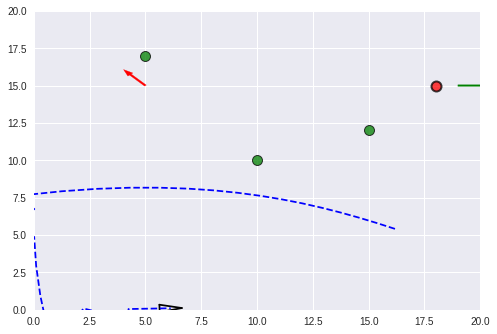

Step 78
Action:  [ 0.22061984 -0.388012  ]
obs= [ 7.8997726   0.23373085  7.1002274  14.766269    6.          8.        ] reward= -3.7762288278056064 done= False


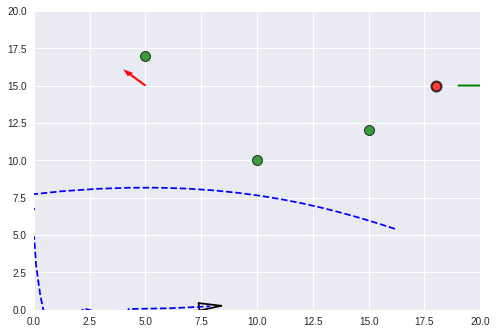

Step 79
Action:  [ 0.2063824 -0.3365329]
obs= [ 9.551577    0.42275774  5.4484234  14.577242    6.          8.        ] reward= -3.5866496381424824 done= False


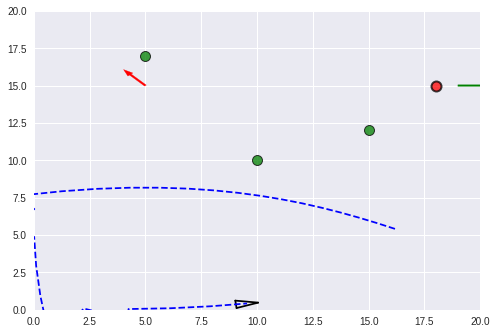

Step 80
Action:  [ 0.19269565 -0.28809568]
obs= [11.097106    0.65869474  3.902894   14.341306    6.          8.        ] reward= -3.4025665450404823 done= False


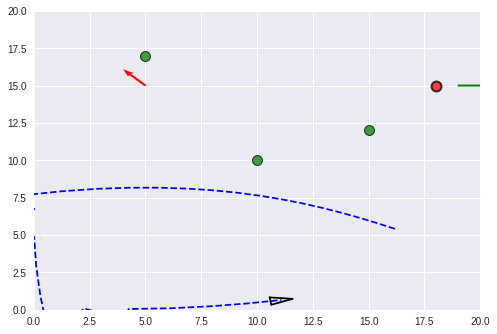

Step 81
Action:  [ 0.17269473 -0.22703154]
obs= [12.545892   0.9286258  2.4541082 14.071374   6.         8.       ] reward= -3.2244199381140306 done= False


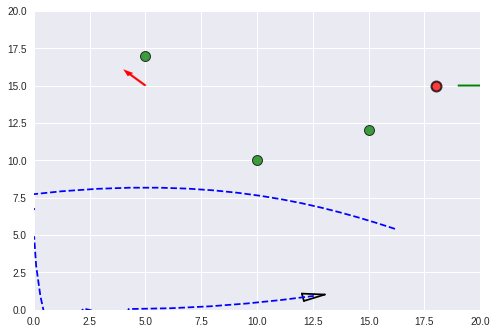

Step 82
Action:  [ 0.15337588 -0.16899332]
obs= [13.9079     1.222175   1.0920997 13.777825   6.         8.       ] reward= -3.0525482480249746 done= False


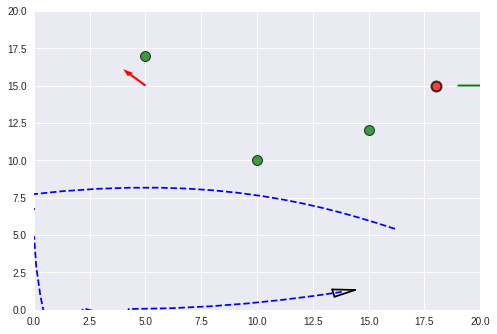

Step 83
Action:  [ 0.13792163 -0.11571603]
obs= [15.193104    1.5318396  -0.19310346 13.468161    6.          8.        ] reward= -2.8869924660919857 done= False


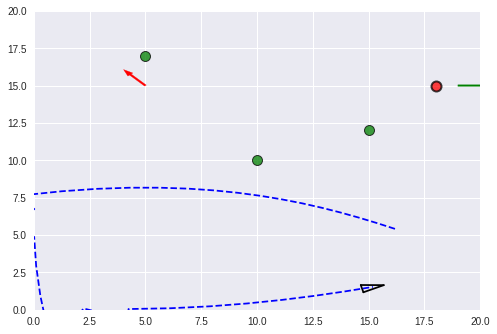

Step 84
Action:  [ 0.11944221 -0.0506281 ]
obs= [16.41172    1.8506403 -1.4117194 13.14936    6.         8.       ] reward= -2.766126387731199 done= False


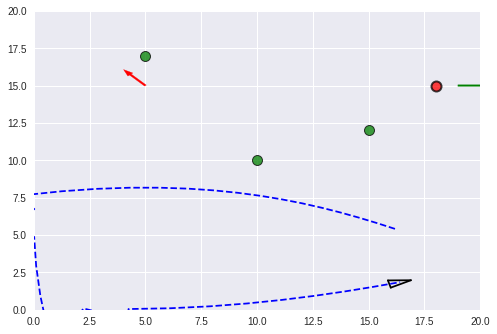

Step 85
Action:  [0.09629416 0.02497804]
obs= [17.57431    2.1718578 -2.5743108 12.828142   6.         8.       ] reward= -2.85610791658459 done= False


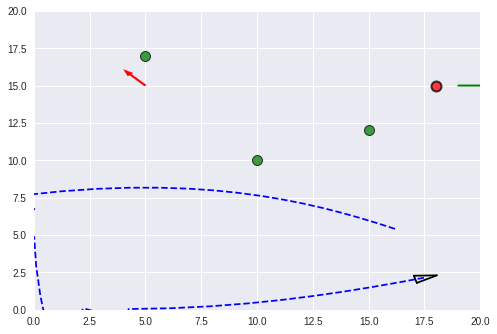

Step 86
Action:  [0.0742713  0.09113548]
obs= [18.69136    2.4906235 -3.6913598 12.509377   6.         8.       ] reward= -2.9402453035673184 done= False


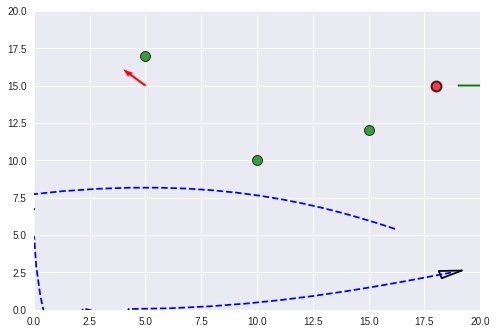

Step 87
Action:  [0.05721868 0.13878681]
obs= [19.77294    2.8044426 -4.7729387 12.195558   6.         8.       ] reward= -3.020073637809544 done= False


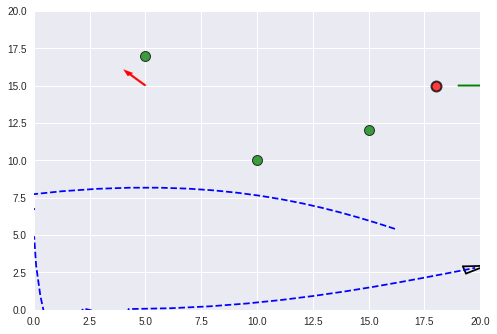

Step 88
Action:  [0.04419116 0.17369768]
obs= [20.828743   3.1124072 -5.8287435 11.887593   6.         8.       ] reward= -3.096849621950441 done= False


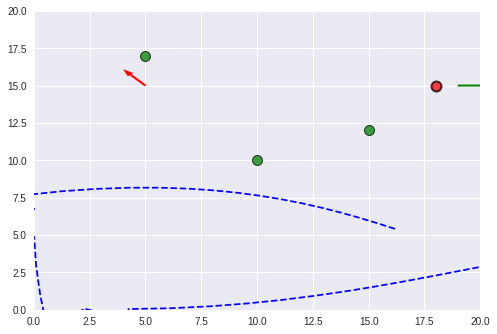

Step 89
Action:  [0.03338601 0.20241156]
obs= [21.86823    3.4144115 -6.8682303 11.585588   6.         8.       ] reward= -3.17163363849343 done= False


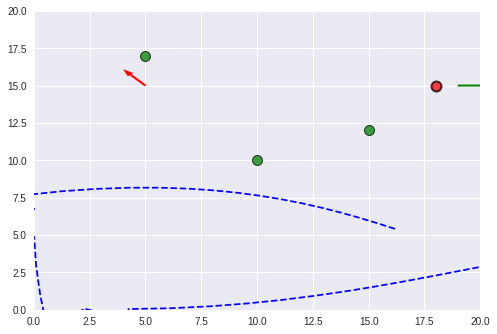

Step 90
Action:  [0.02377538 0.2271969 ]
obs= [22.900726  3.71075  -7.900727 11.289249  6.        8.      ] reward= -3.2453818638000733 done= False


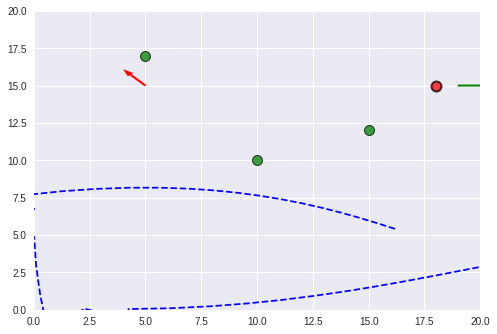

Step 91
Action:  [0.0151515  0.24745058]
obs= [23.9355     4.0019813 -8.935499  10.998018   6.         8.       ] reward= -3.3189976736163427 done= False


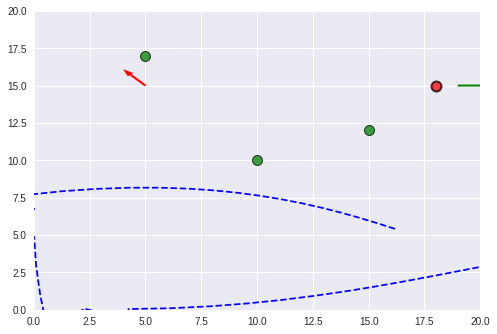

Step 92
Action:  [0.00762466 0.26291037]
obs= [24.981806   4.2888584 -9.981806  10.711142   6.         8.       ] reward= -3.3933517636939343 done= False


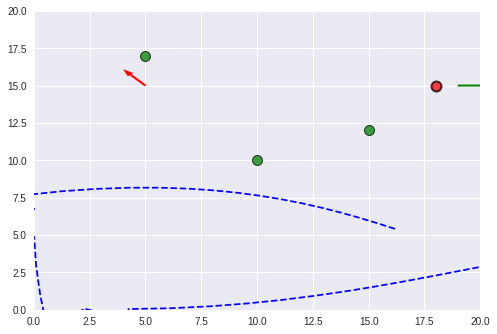

Step 93
Action:  [0.00132104 0.27388668]
obs= [ 26.048958   4.572271 -11.048958  10.42773    6.         8.      ] reward= -3.469294722532498 done= False


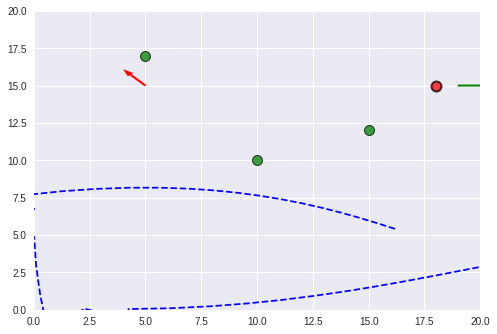

Step 94
Action:  [-0.00386826  0.28181943]
obs= [ 27.14639     4.8531356 -12.146391   10.146864    6.          8.       ] reward= -3.5476686806765843 done= False


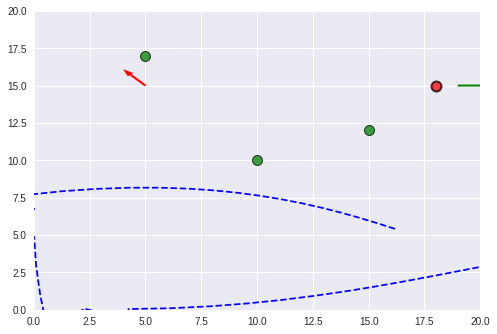

Step 95
Action:  [-0.00822622  0.28836605]
obs= [ 28.283754   5.132271 -13.283754   9.867729   6.         8.      ] reward= -3.6293255182777573 done= False


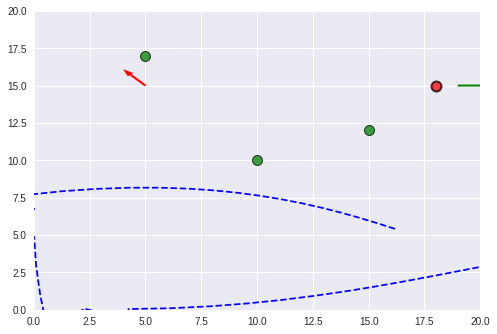

Step 96
Action:  [-0.01191639  0.29400256]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


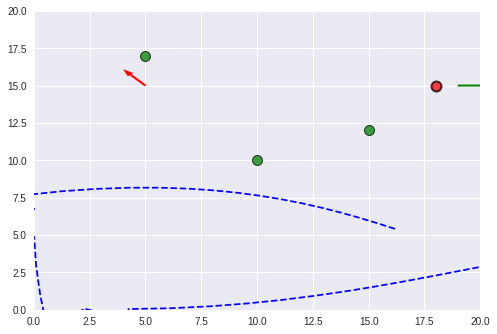

Step 97
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


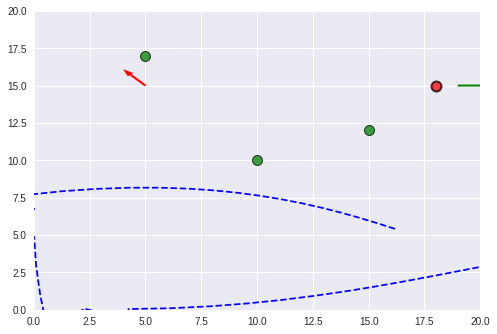

Step 98
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


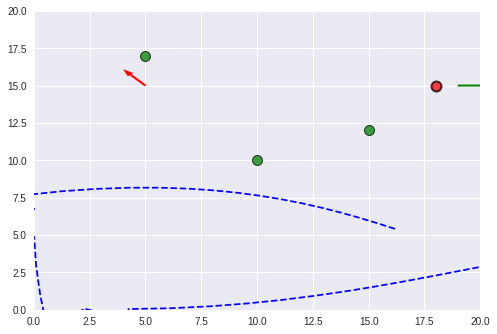

Step 99
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


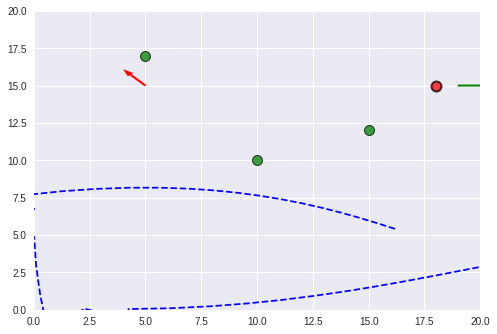

Step 100
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


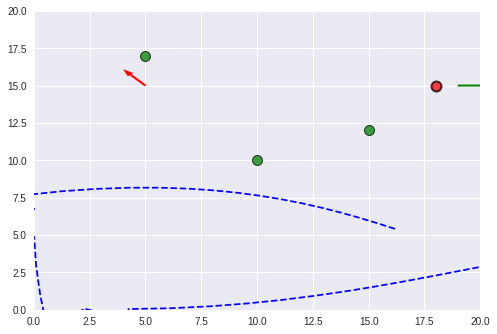

Step 101
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


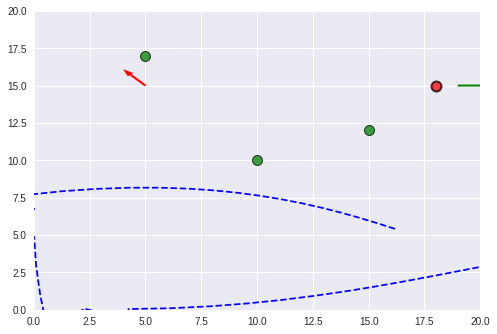

Step 102
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


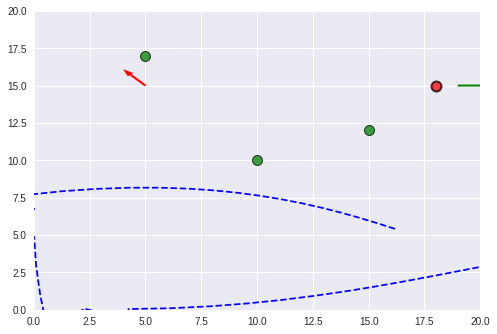

Step 103
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


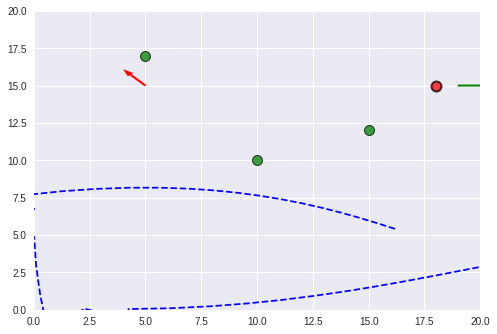

Step 104
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


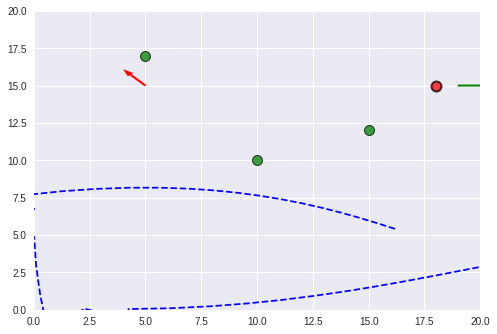

Step 105
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


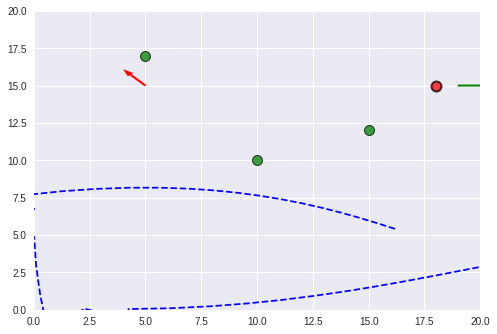

Step 106
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


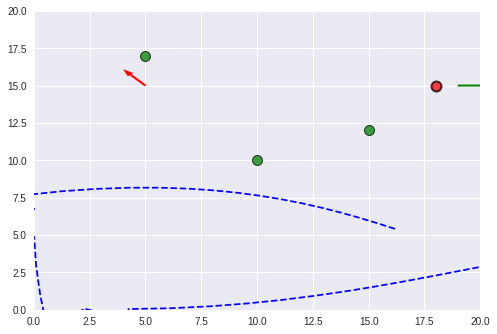

Step 107
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


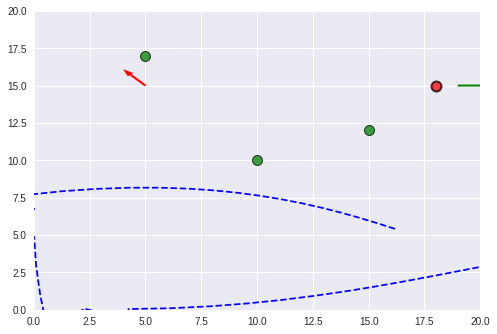

Step 108
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


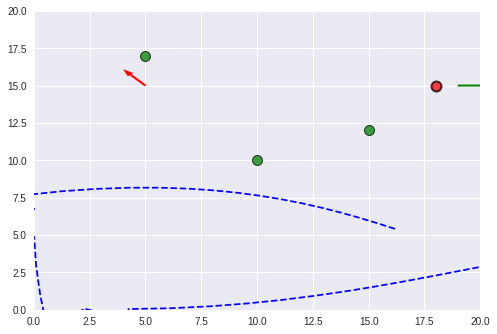

Step 109
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


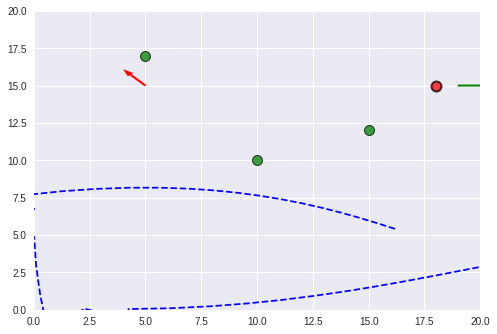

Step 110
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


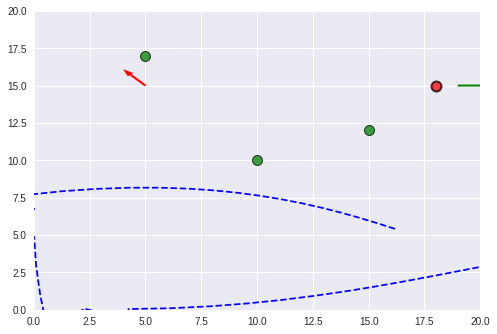

Step 111
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


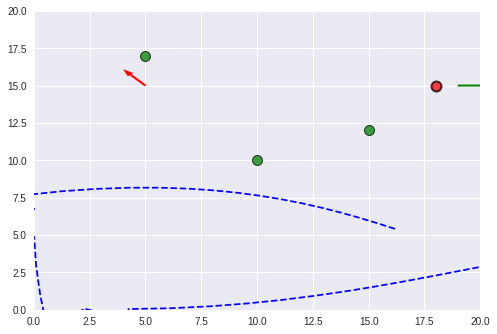

Step 112
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


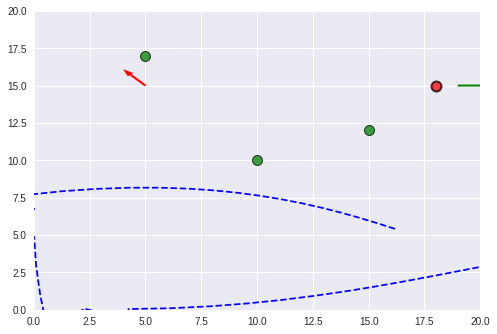

Step 113
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


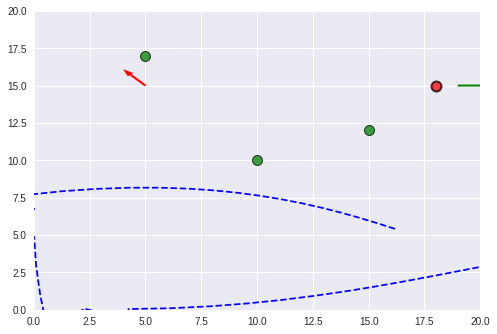

Step 114
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


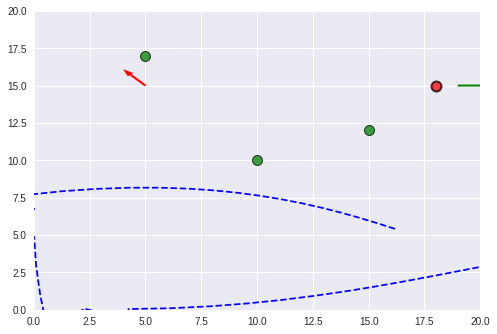

Step 115
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


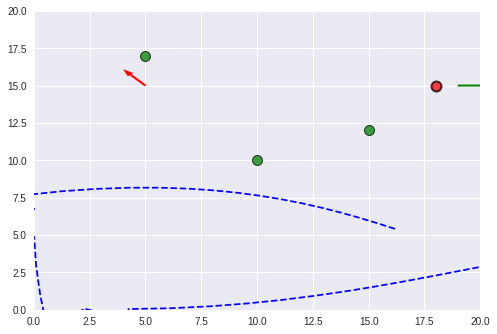

Step 116
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


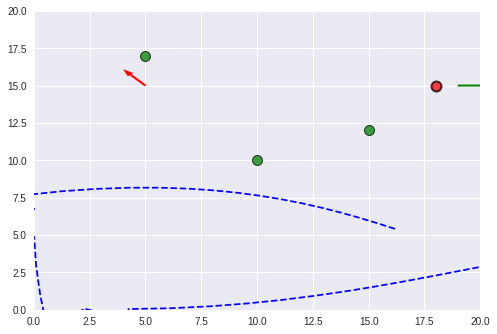

Step 117
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


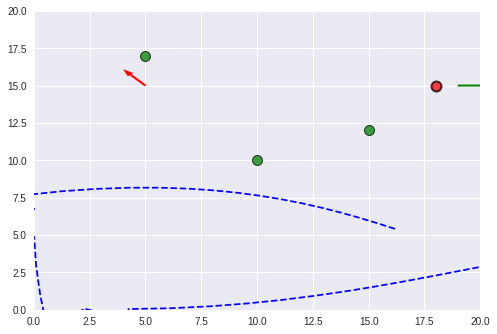

Step 118
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


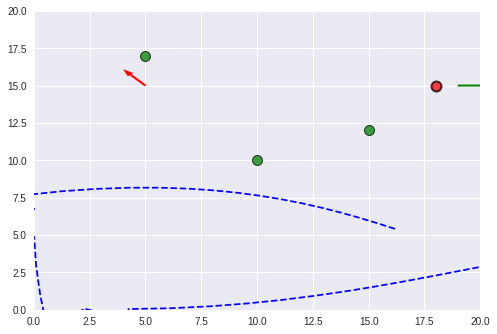

Step 119
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


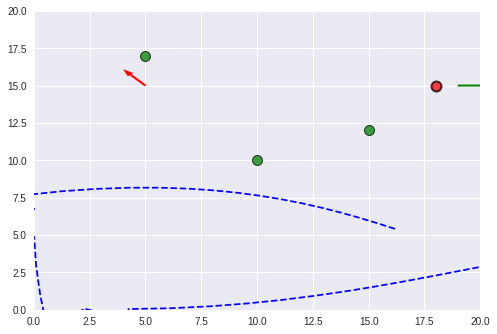

Step 120
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


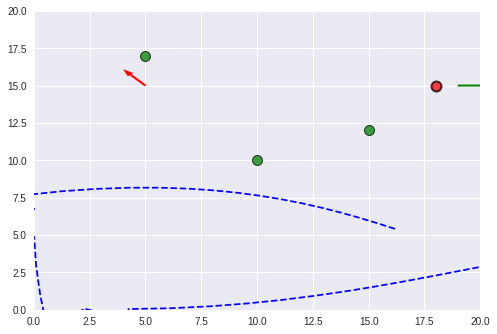

Step 121
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


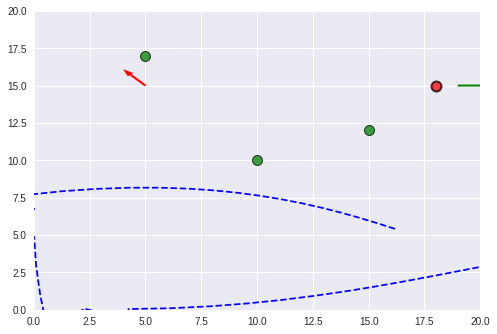

Step 122
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


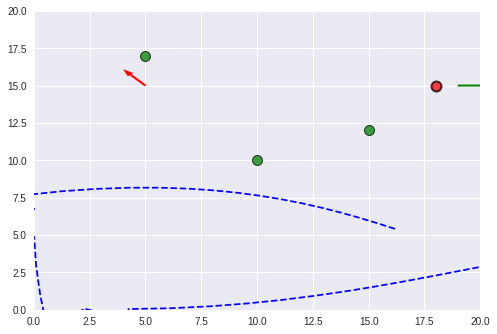

Step 123
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


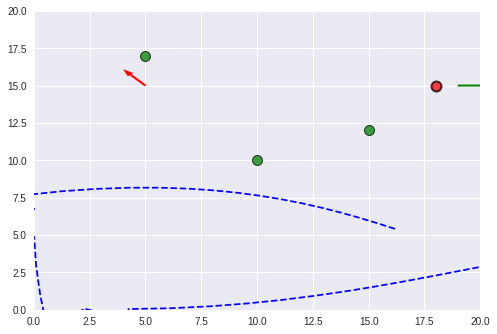

Step 124
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


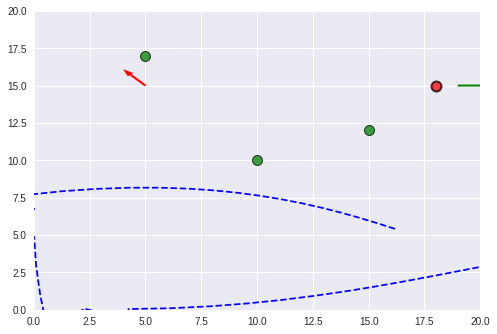

Step 125
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


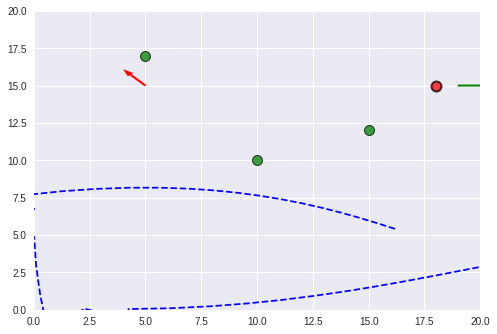

Step 126
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


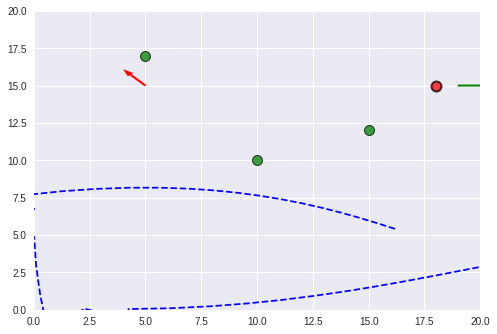

Step 127
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


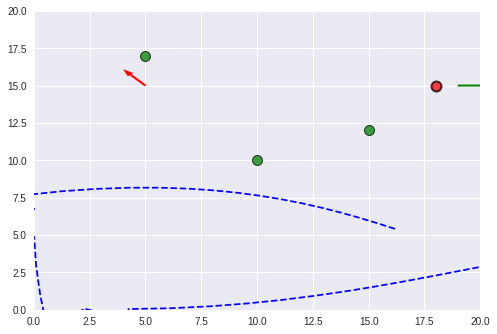

Step 128
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


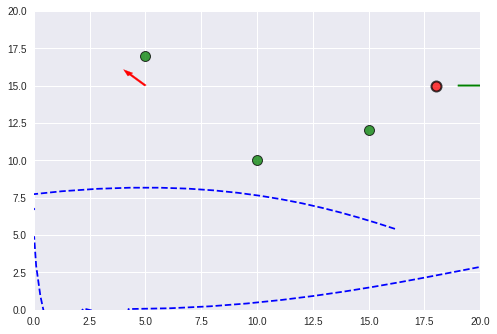

Step 129
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


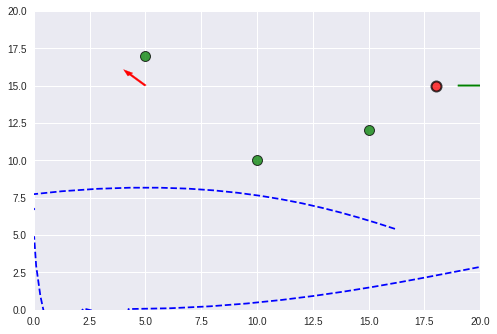

Step 130
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


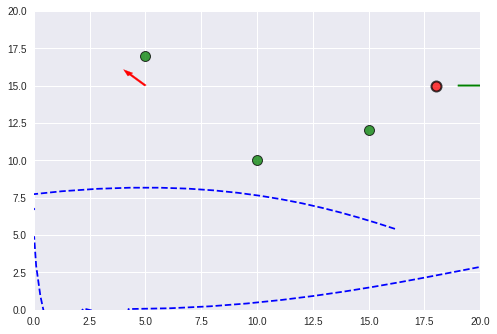

Step 131
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


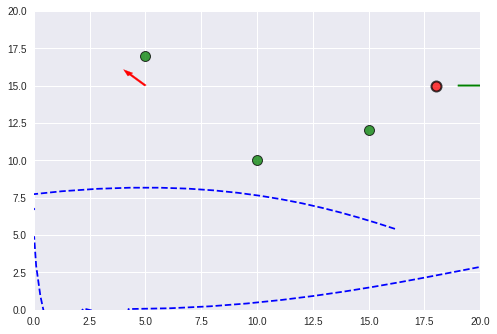

Step 132
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


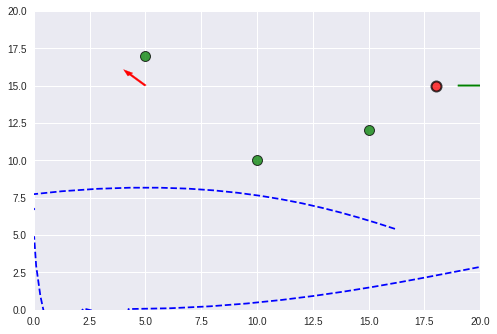

Step 133
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


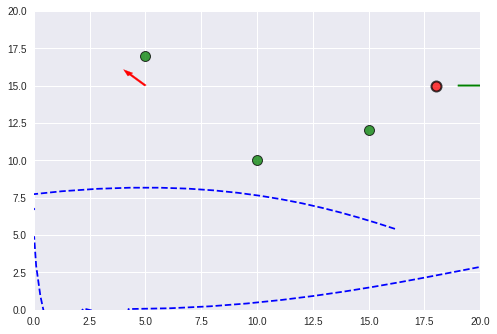

Step 134
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


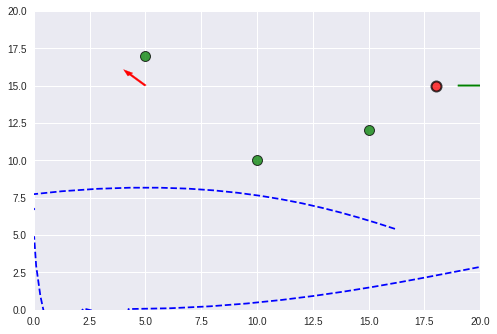

Step 135
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


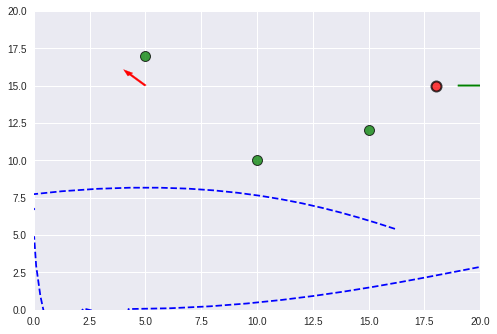

Step 136
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


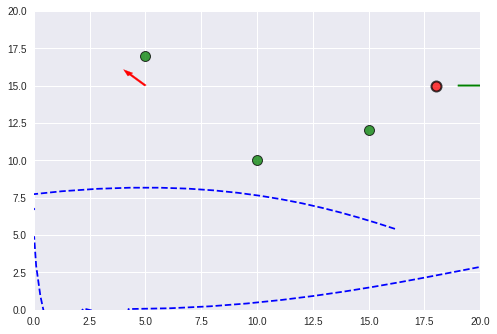

Step 137
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


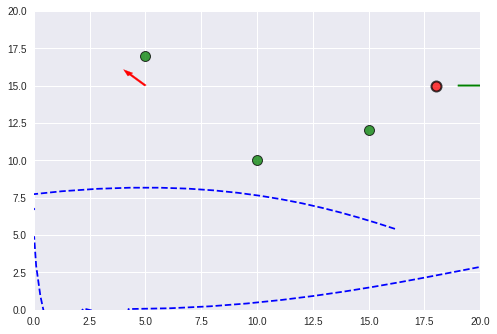

Step 138
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


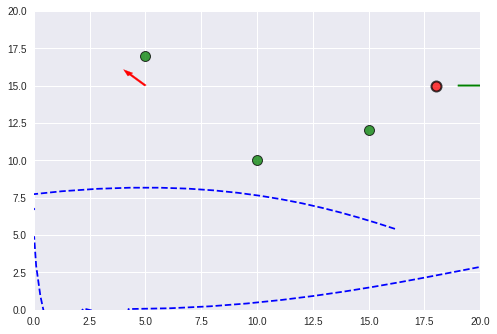

Step 139
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


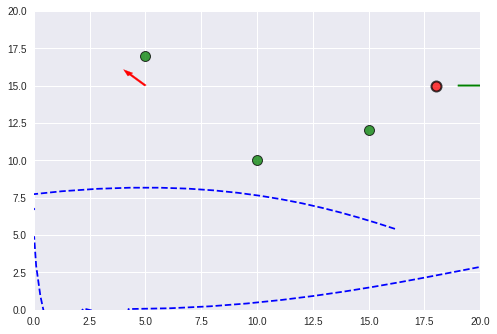

Step 140
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


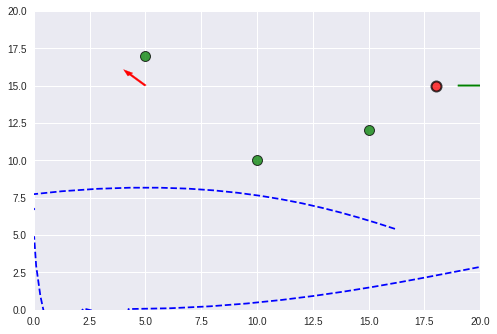

Step 141
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


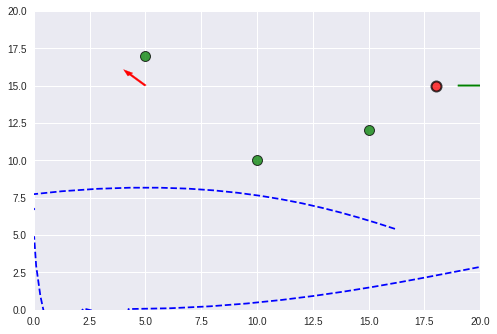

Step 142
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


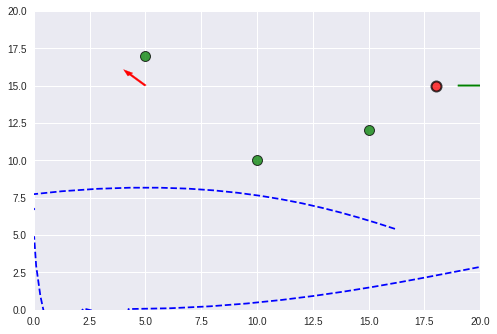

Step 143
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


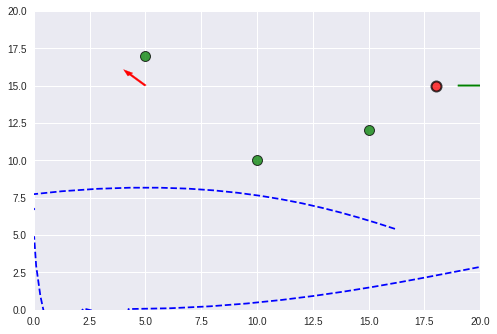

Step 144
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


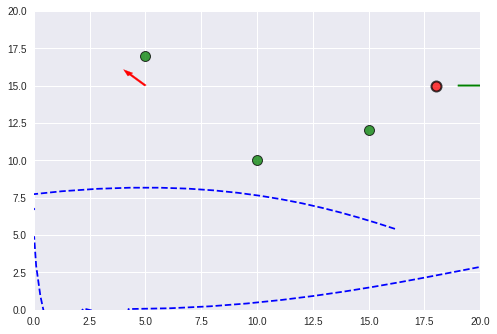

Step 145
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


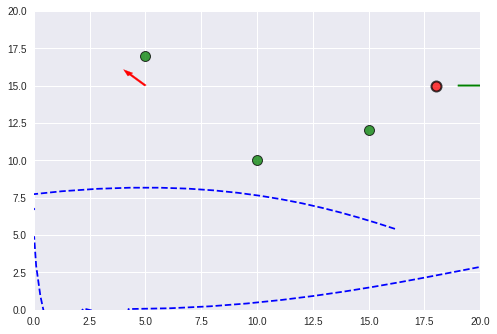

Step 146
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


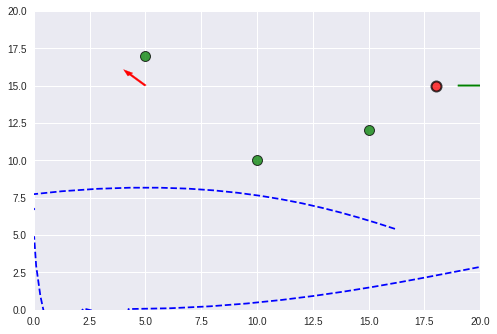

Step 147
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


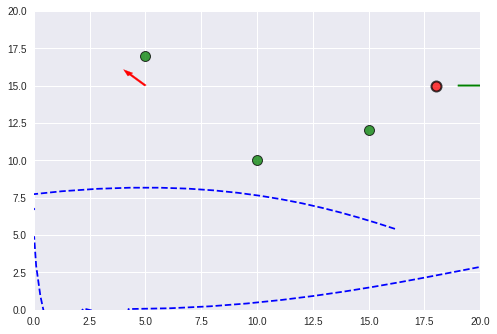

Step 148
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


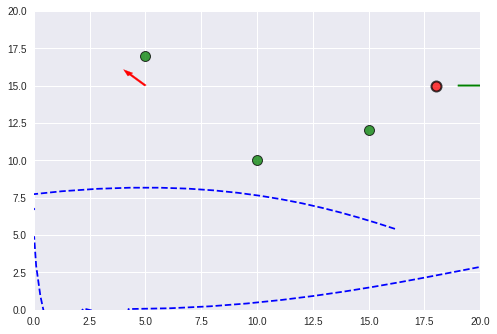

Step 149
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


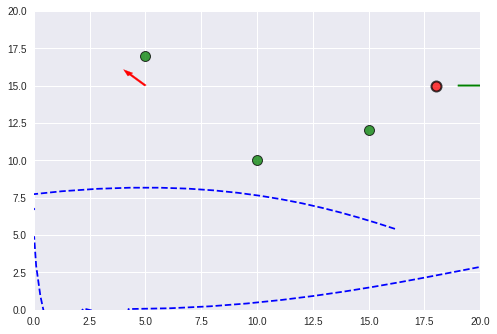

Step 150
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


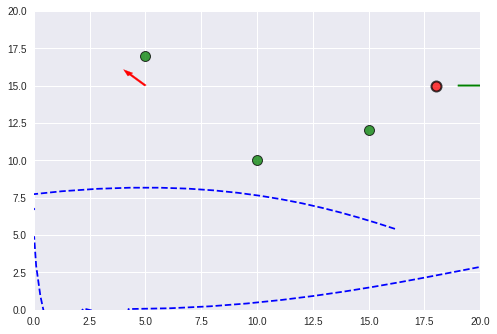

Step 151
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


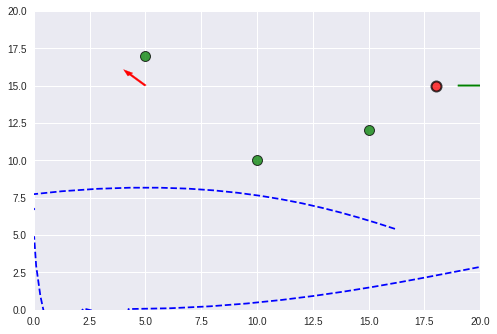

Step 152
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


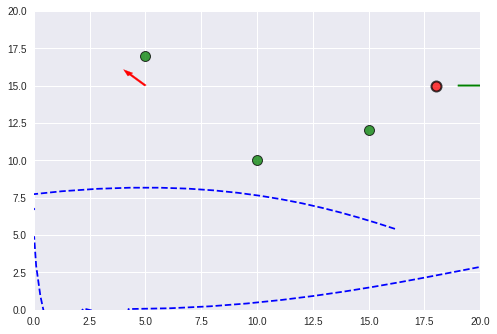

Step 153
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


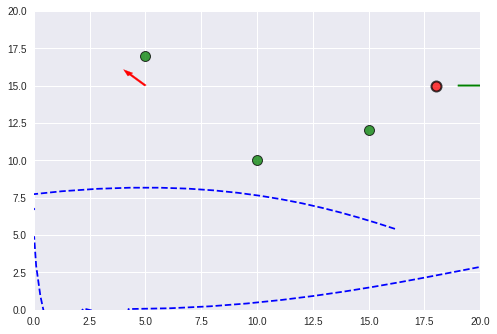

Step 154
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


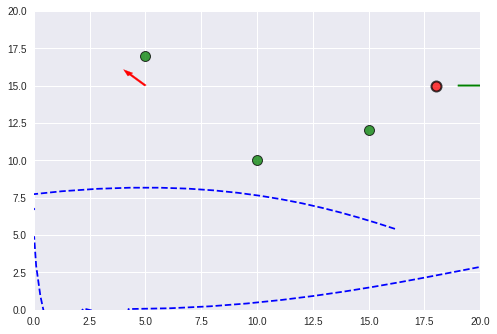

Step 155
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


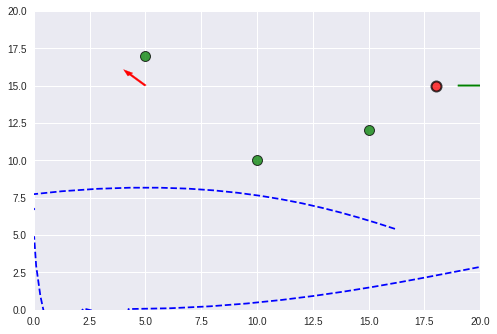

Step 156
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


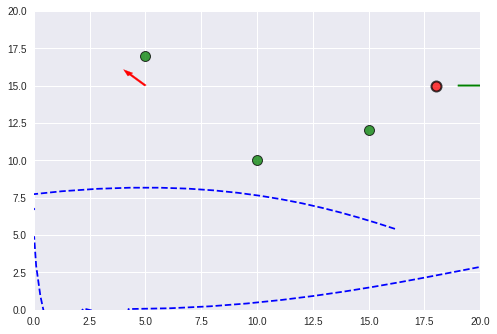

Step 157
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


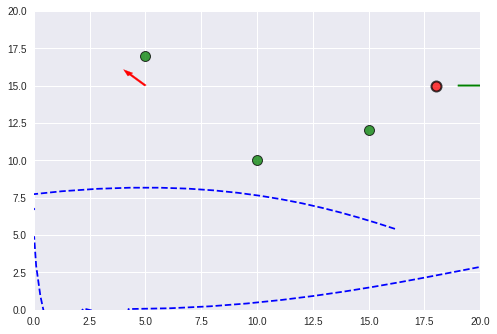

Step 158
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


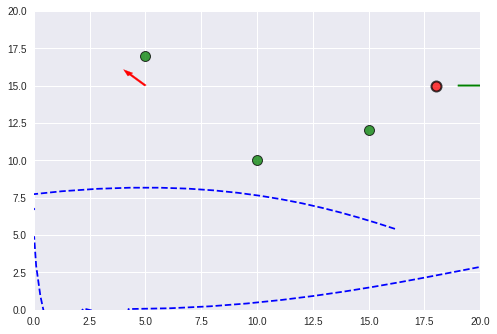

Step 159
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


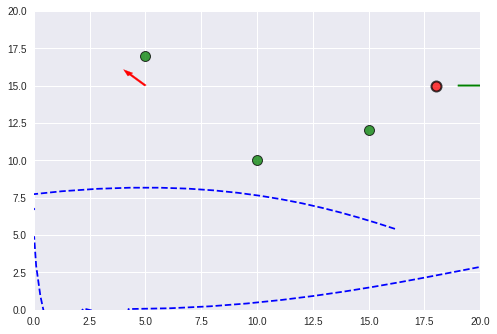

Step 160
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


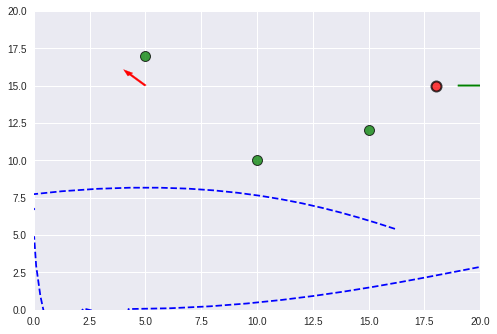

Step 161
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


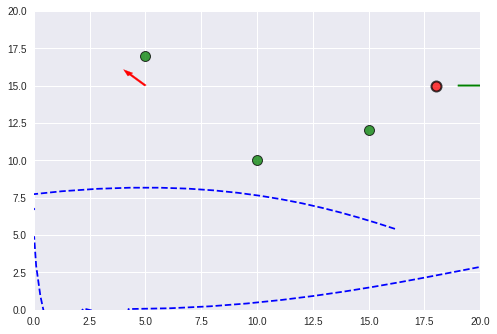

Step 162
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


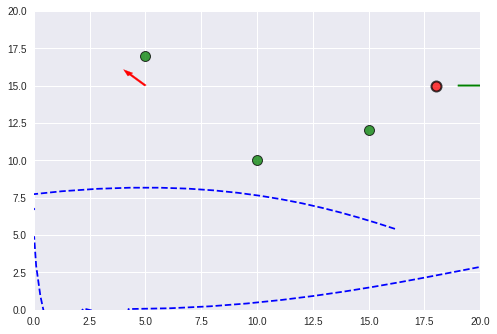

Step 163
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


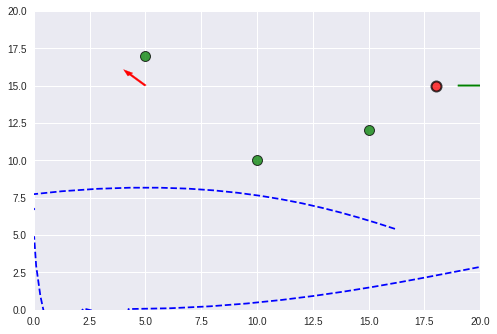

Step 164
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


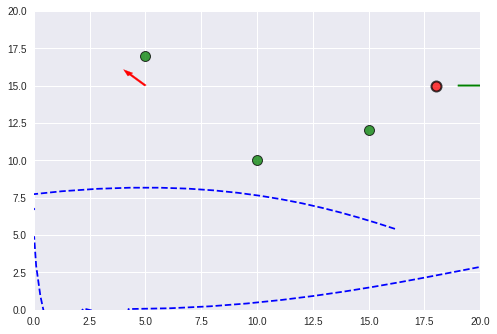

Step 165
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


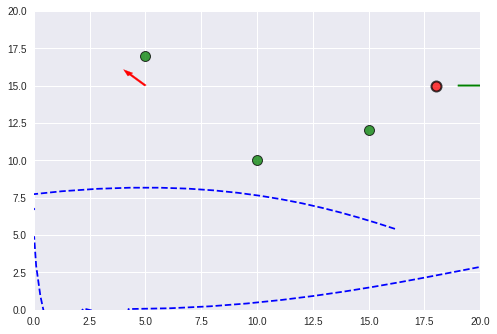

Step 166
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


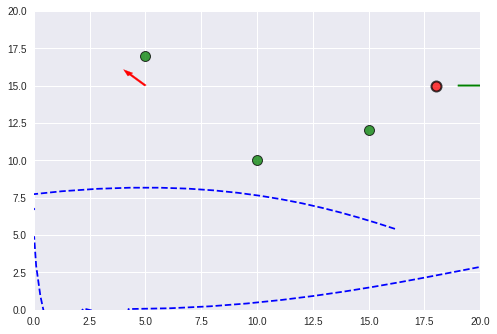

Step 167
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


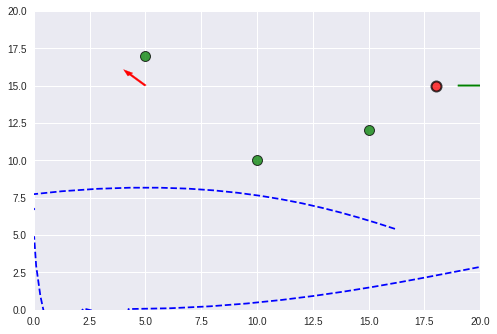

Step 168
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


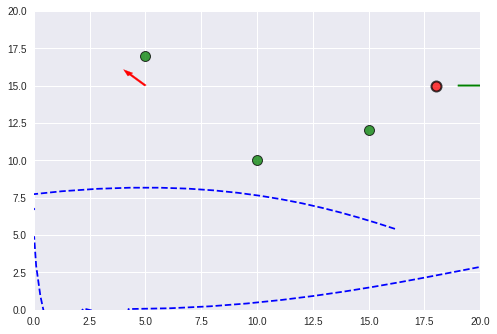

Step 169
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


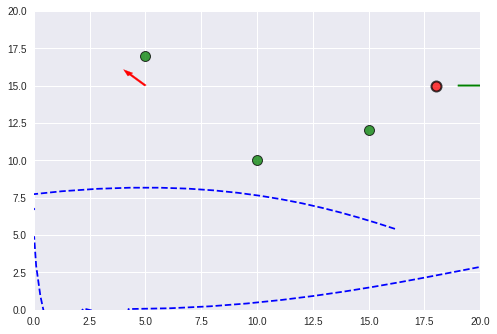

Step 170
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


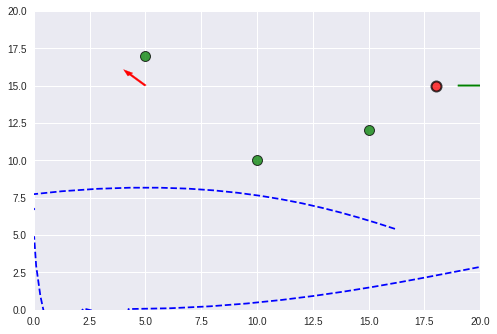

Step 171
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


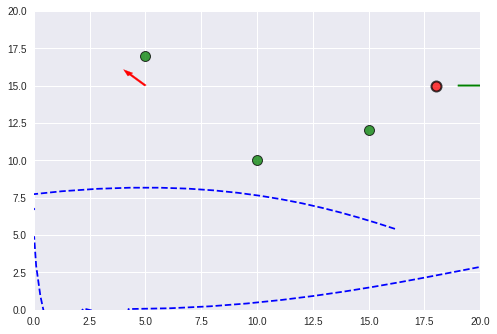

Step 172
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


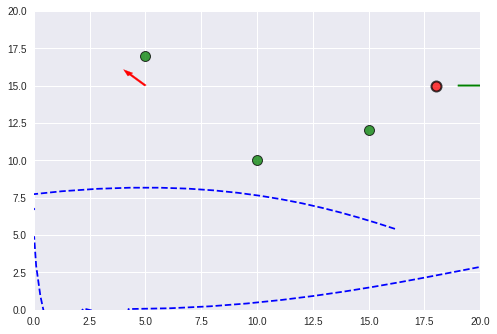

Step 173
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


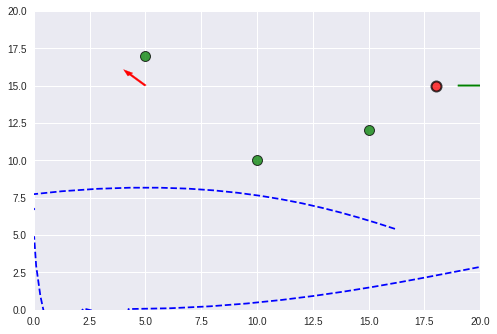

Step 174
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


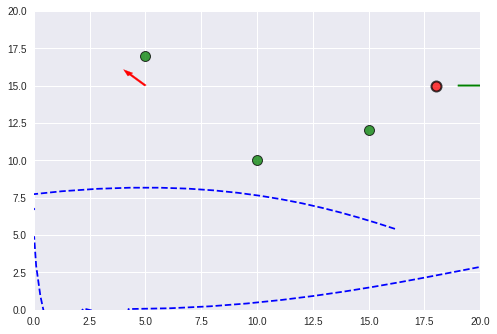

Step 175
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


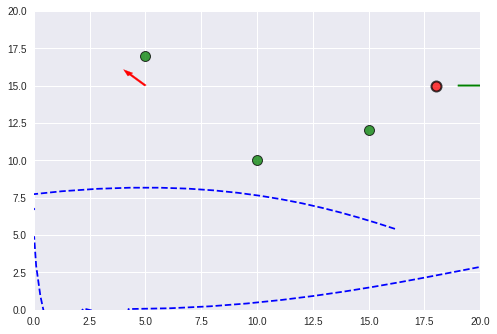

Step 176
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


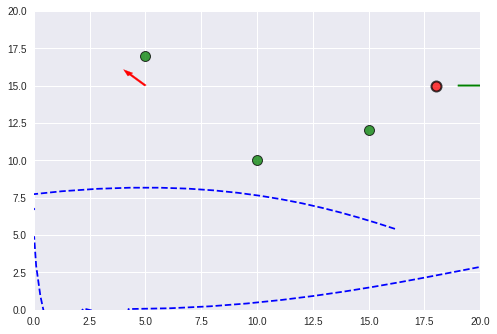

Step 177
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


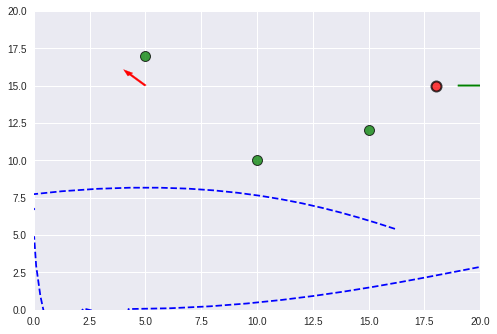

Step 178
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


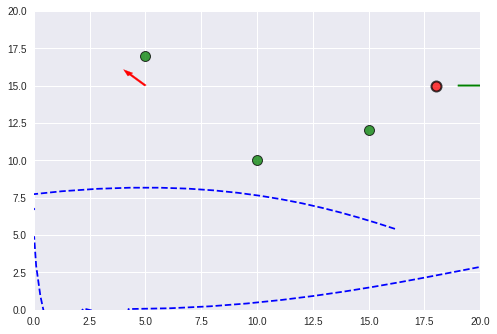

Step 179
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


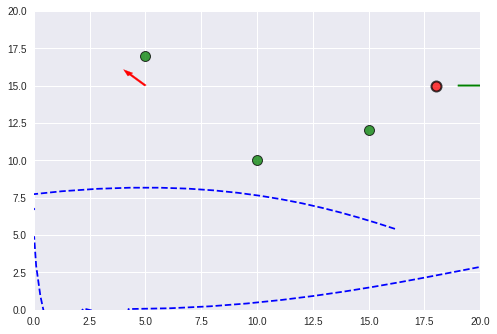

Step 180
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


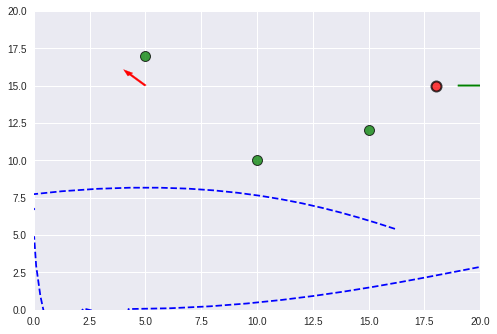

Step 181
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


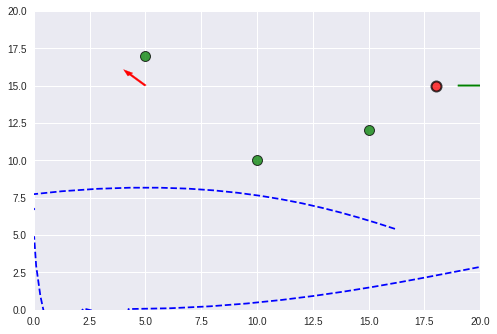

Step 182
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


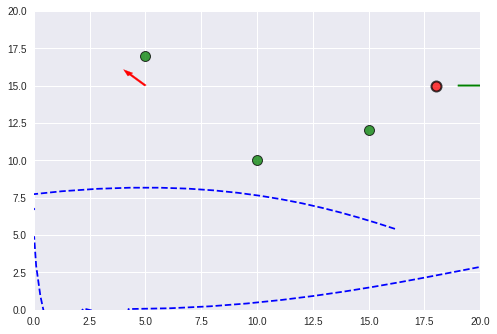

Step 183
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


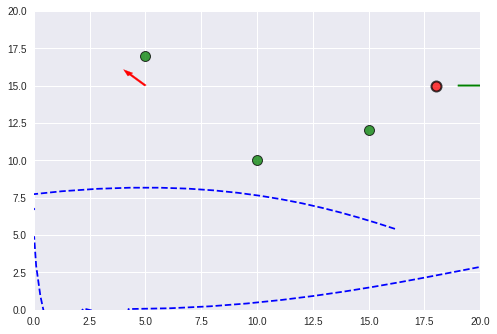

Step 184
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


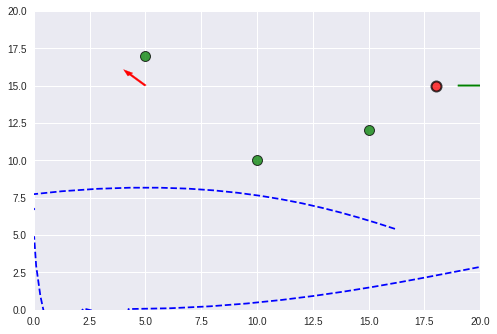

Step 185
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


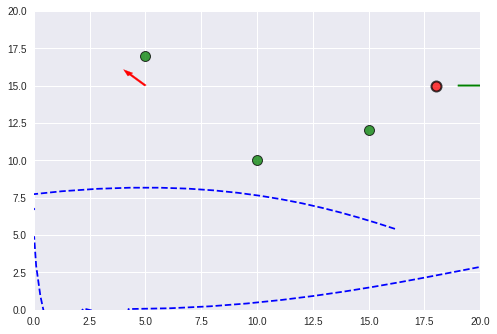

Step 186
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


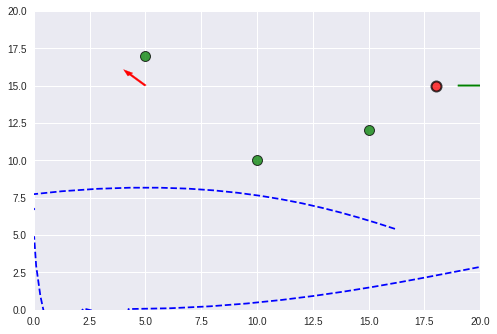

Step 187
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


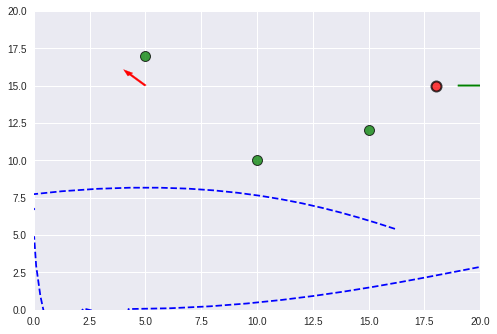

Step 188
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


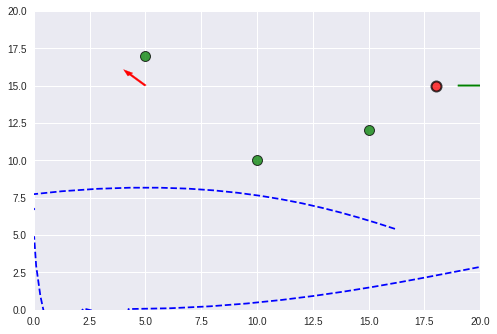

Step 189
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


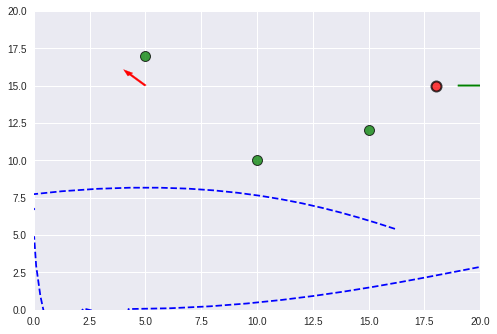

Step 190
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


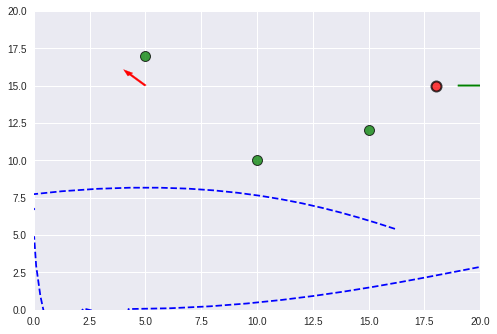

Step 191
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


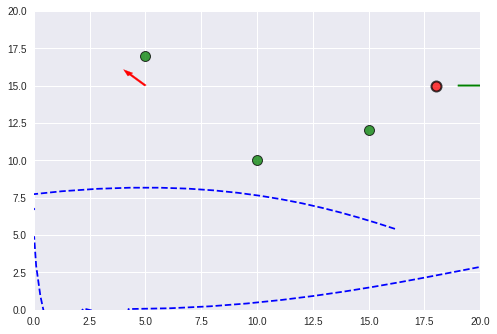

Step 192
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


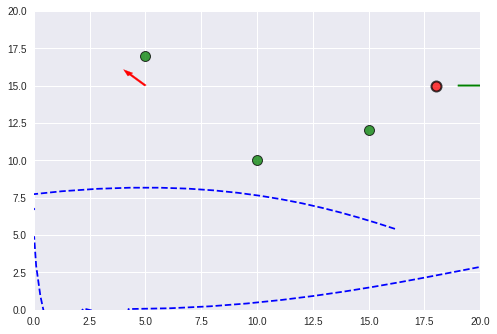

Step 193
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


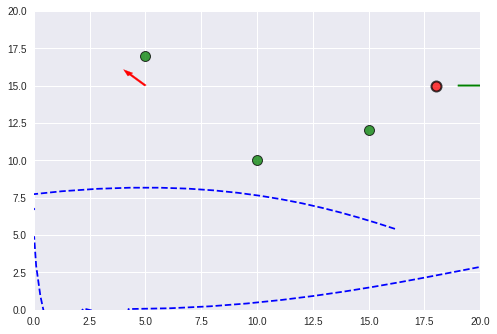

Step 194
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


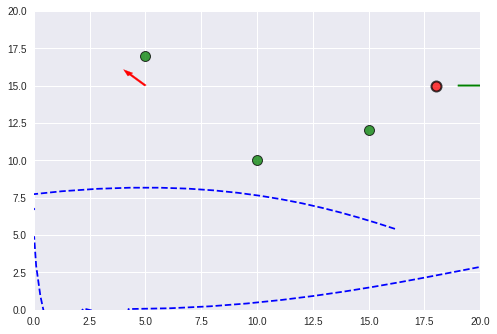

Step 195
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


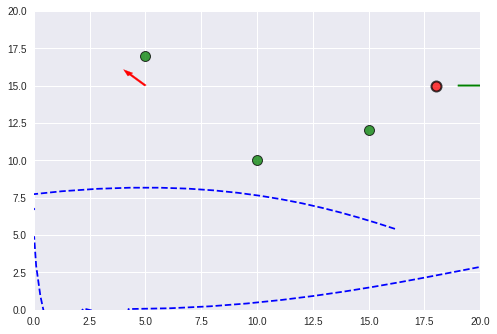

Step 196
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


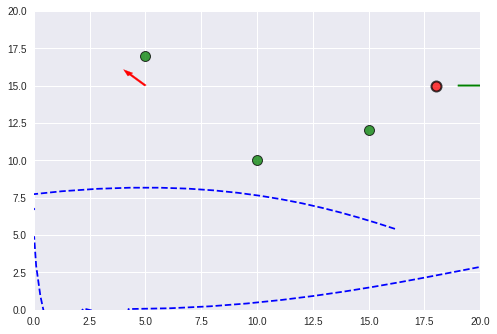

Step 197
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


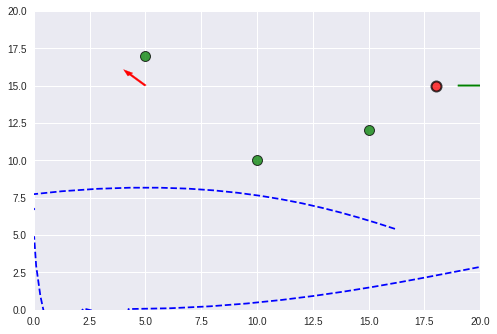

Step 198
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


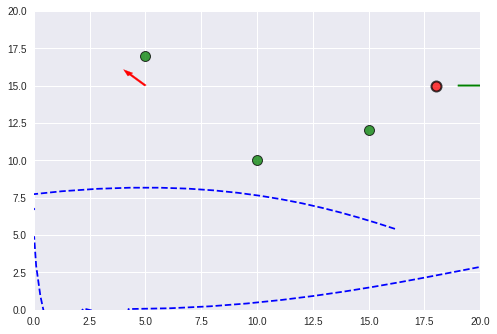

Step 199
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


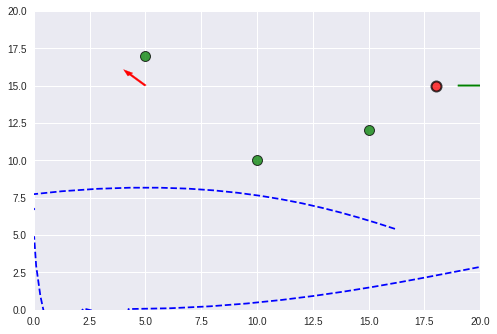

Step 200
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


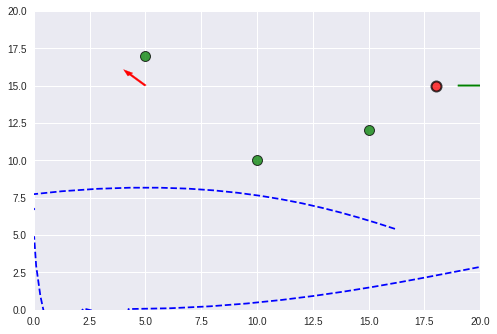

Step 201
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


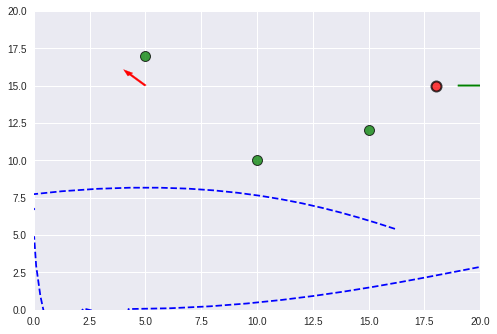

Step 202
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


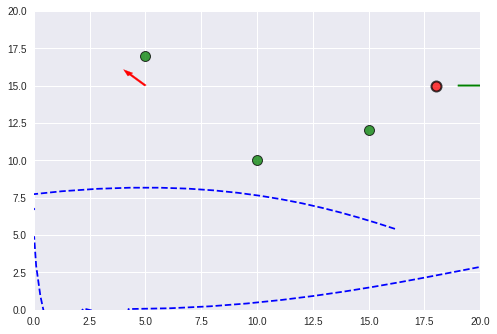

Step 203
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


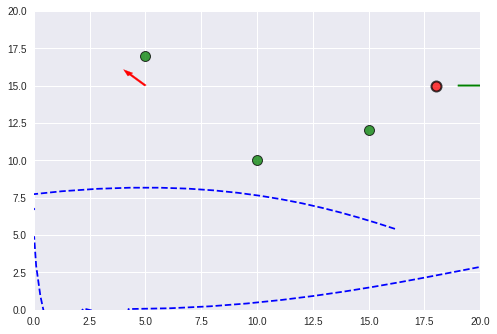

Step 204
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


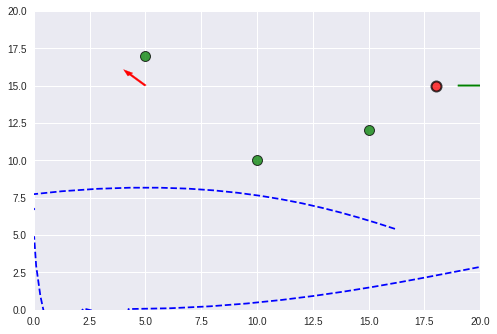

Step 205
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


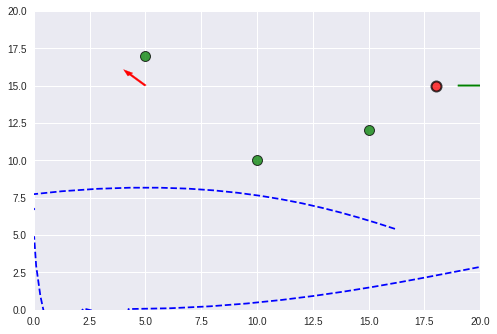

Step 206
Action:  [-0.01501299  0.29831177]
obs= [ 29.470987   5.410327 -14.470987   9.589673   6.         8.      ] reward= -3.7151483828910545 done= False


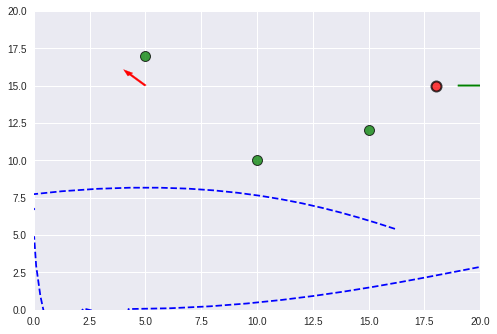

In [ ]:
obs = env.reset()
n_steps = 500
for step in range(n_steps):
  action, _ = model.predict(obs, deterministic=True)
  print("Step {}".format(step + 1))
  print("Action: ", action)
  obs, reward, done, info = env.step(action)
  print('obs=', obs, 'reward=', reward, 'done=', done)
  env.render(mode='console')
  if done:
    # Note that the VecEnv resets automatically
    # when a done signal is encountered
    print("Goal reached!", "reward=", reward)
    break

Initial x: 16.34 m
Initial y: 4.56 m
Initial theta: 2.56 rad

Goal x: 19.00 m
Goal y: 15.00 m
Goal theta: 0.00 rad



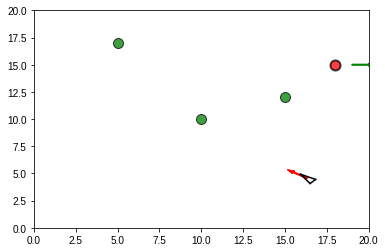

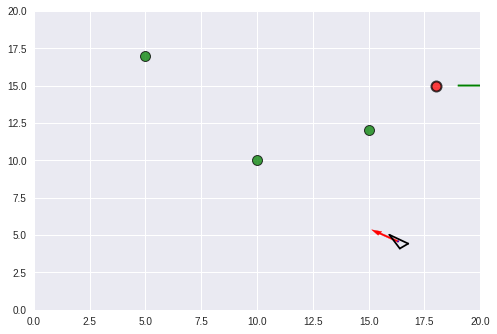

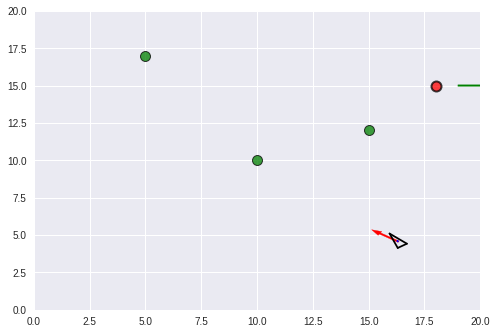

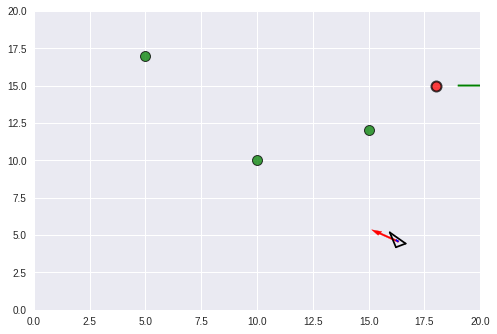

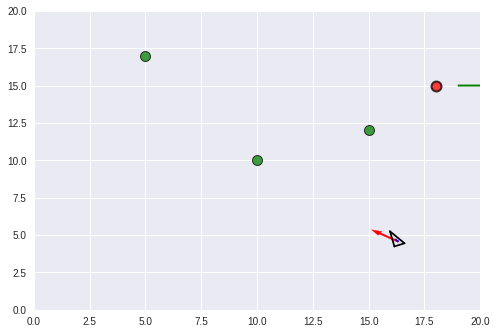

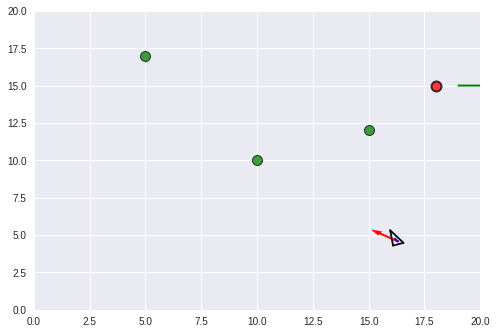

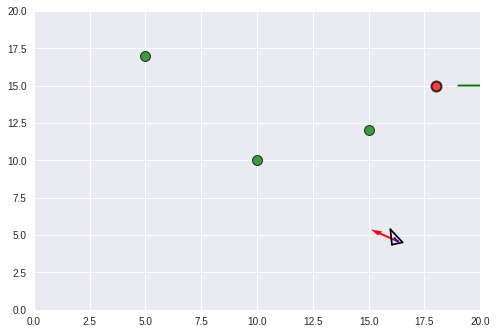

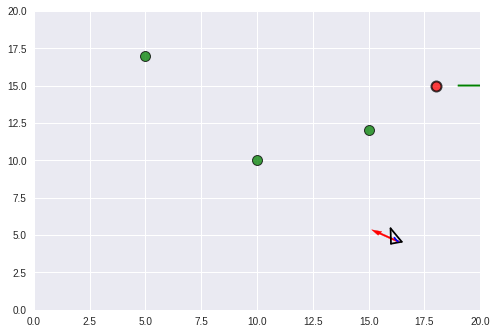

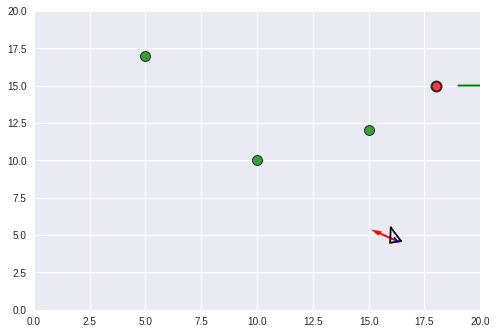

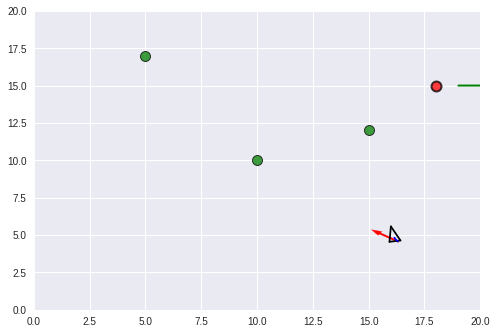

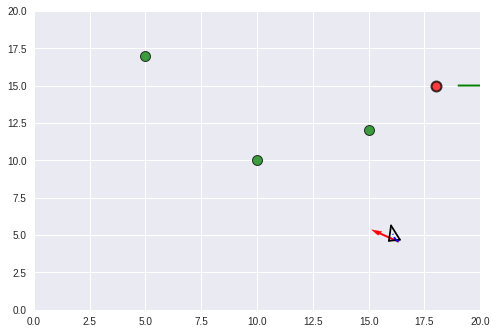

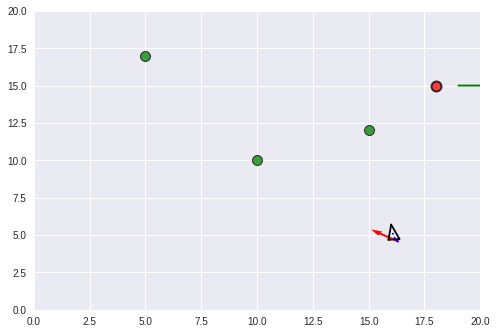

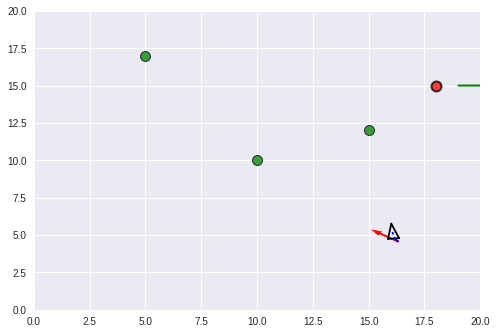

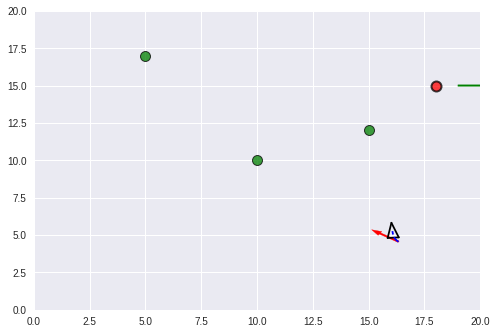

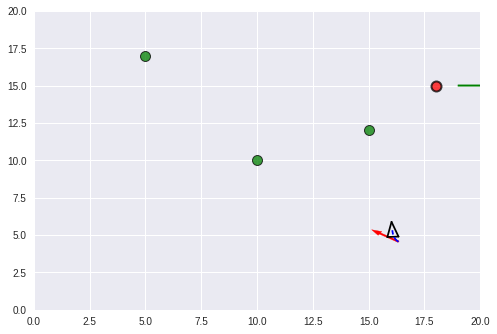

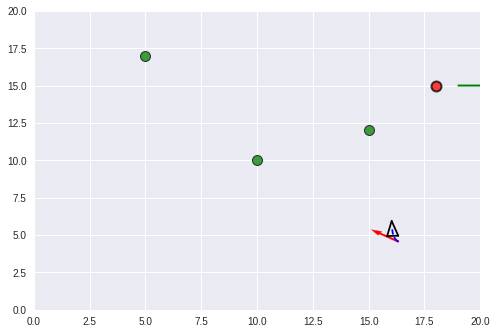

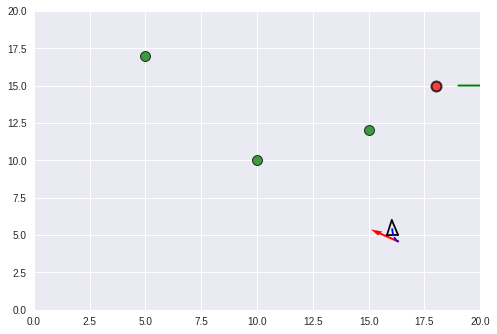

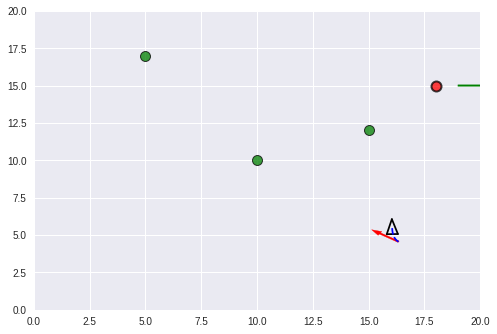

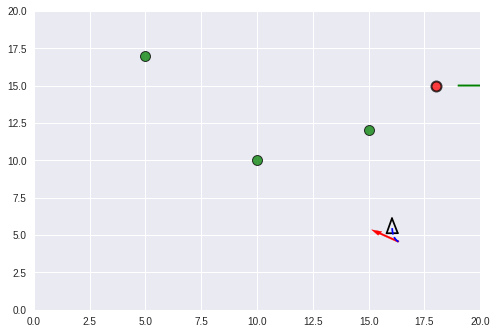

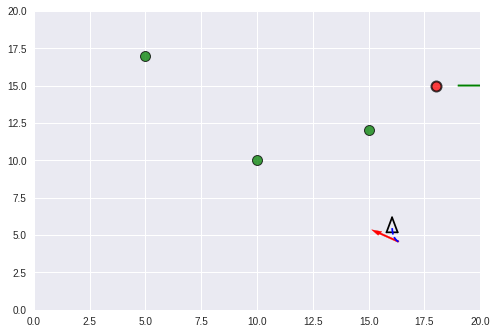

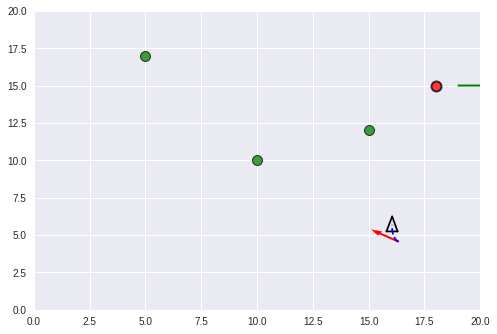

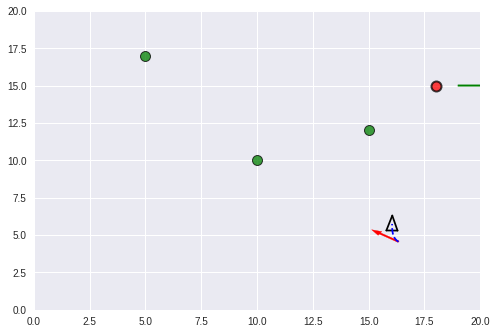

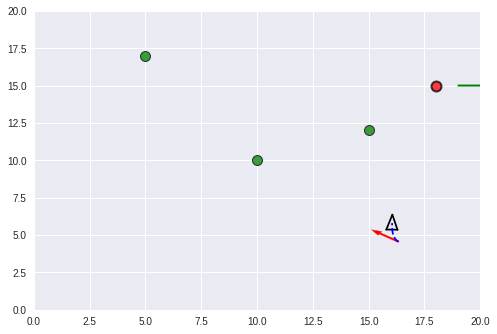

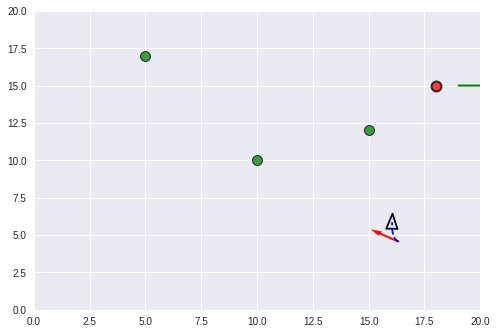

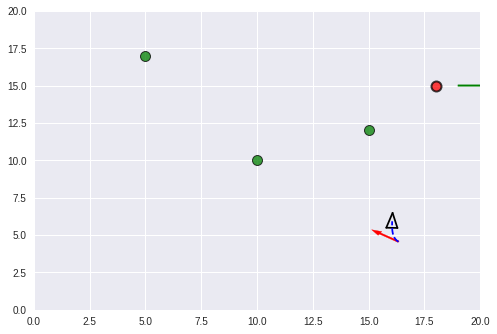

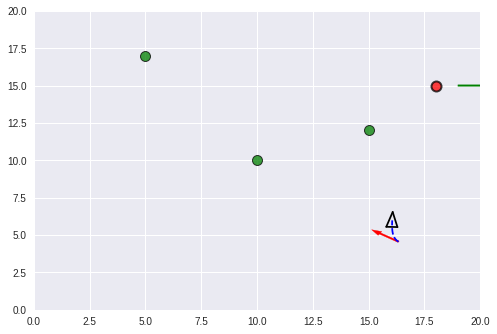

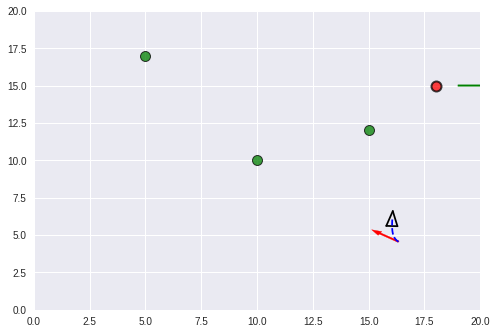

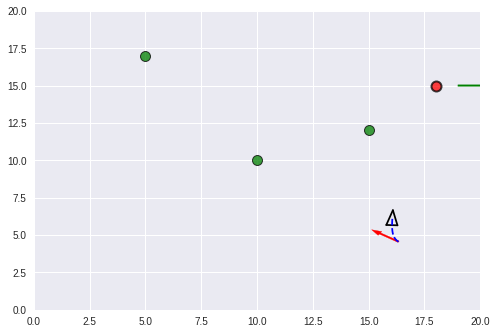

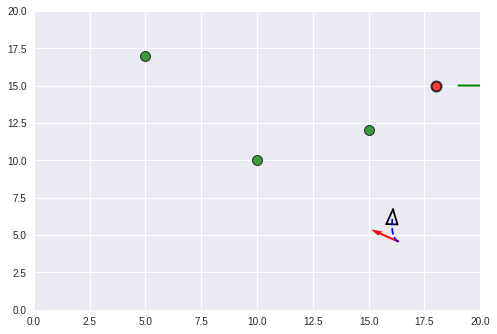

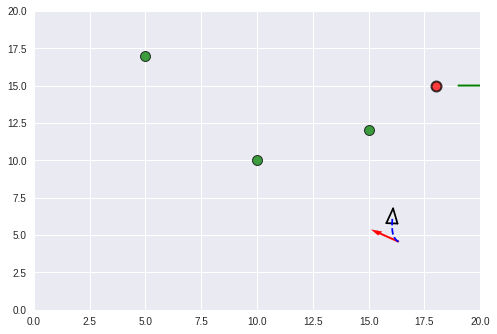

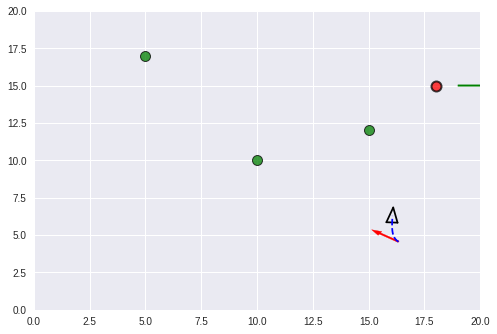

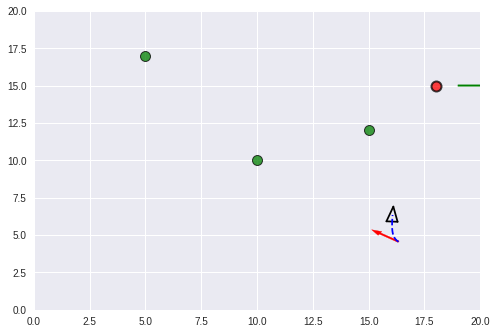

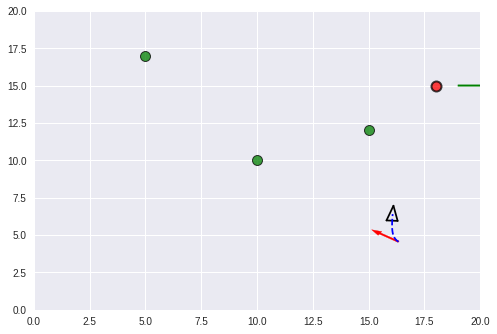

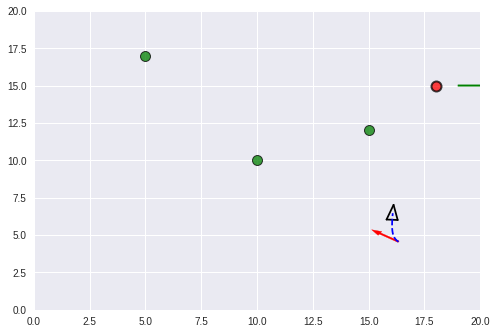

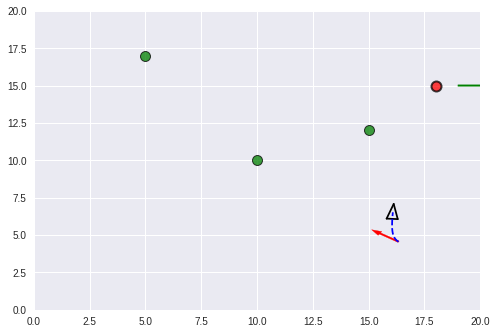

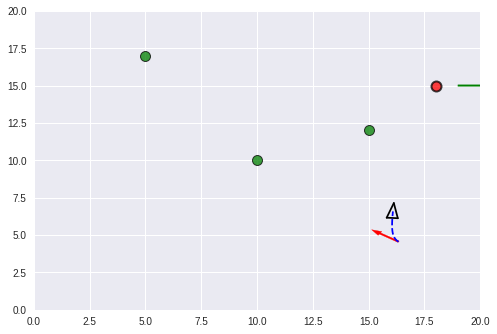

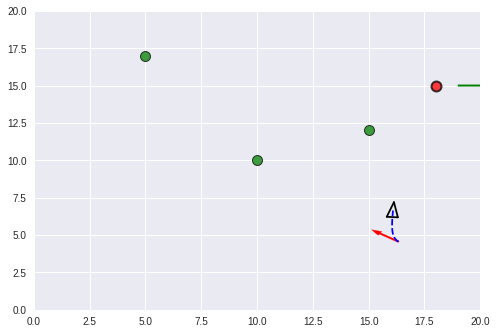

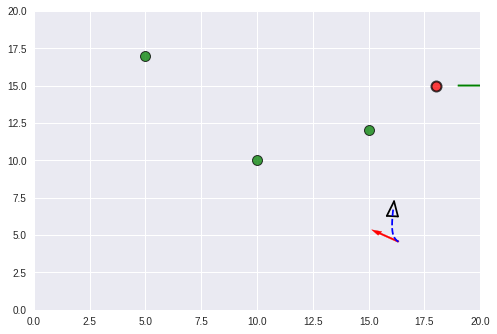

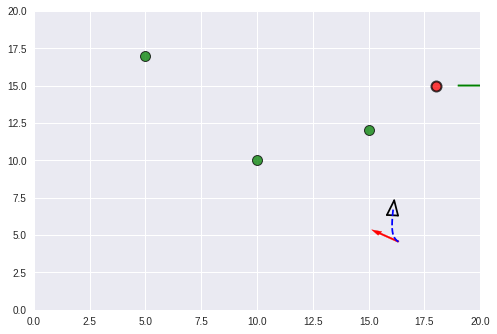

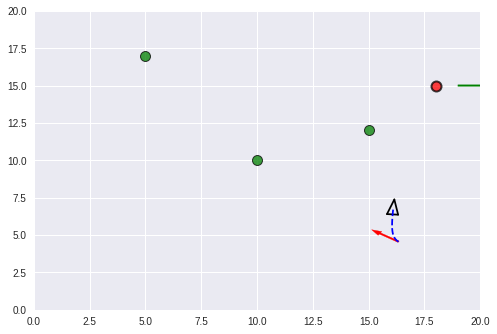

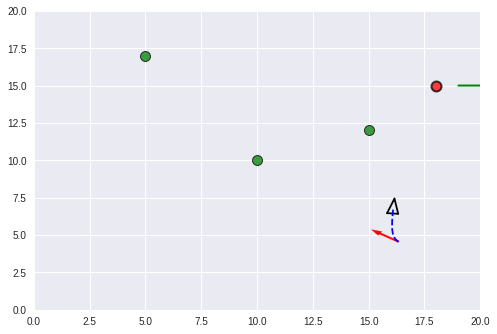

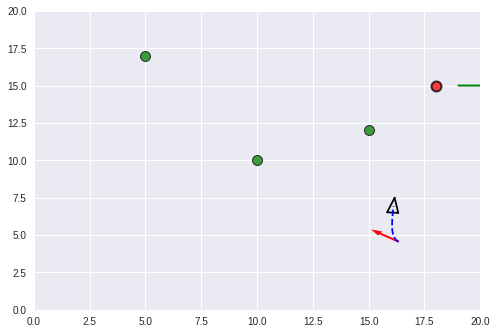

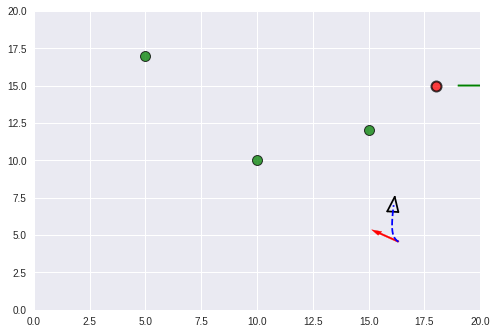

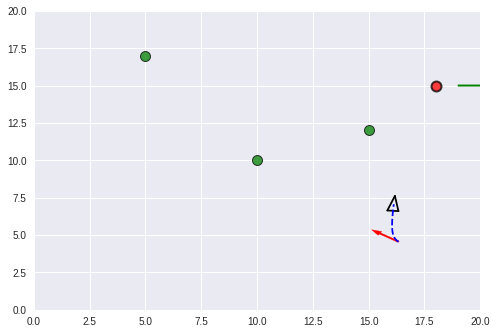

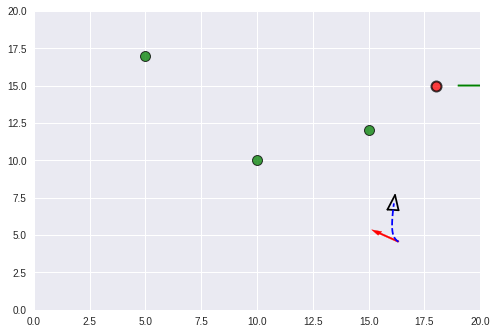

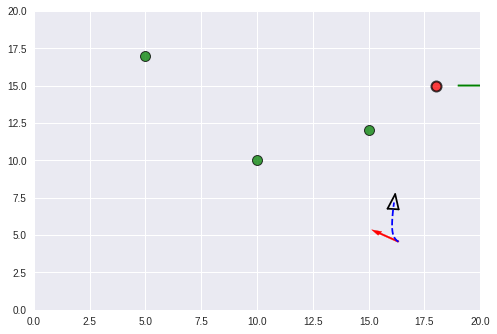

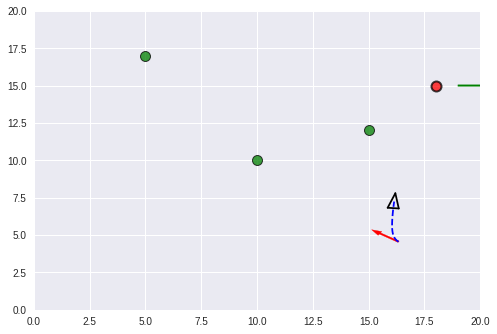

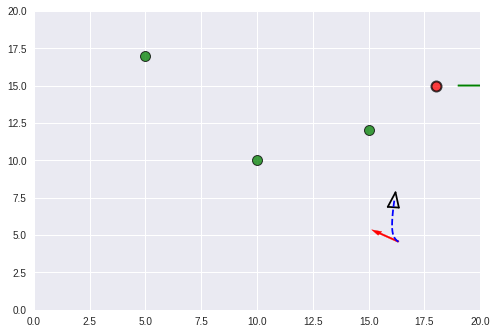

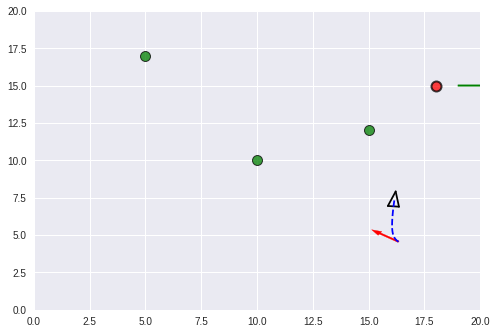

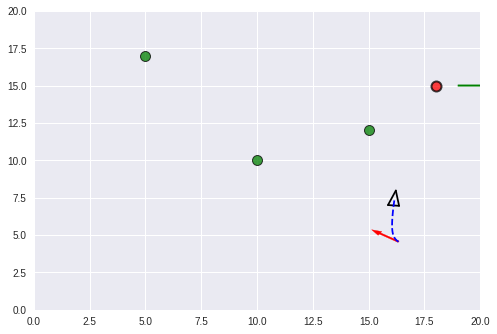

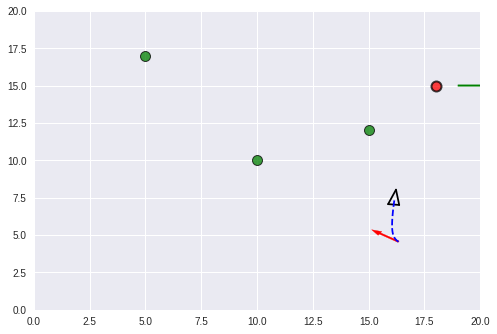

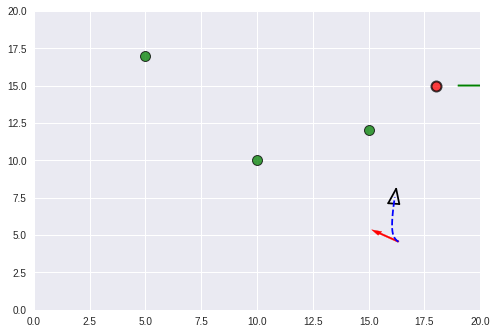

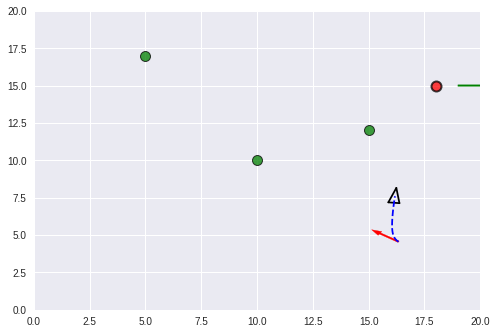

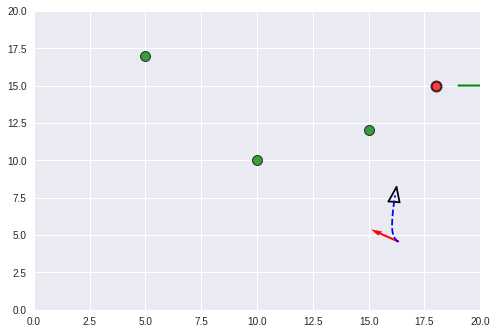

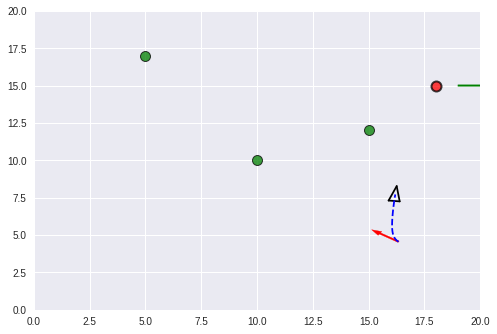

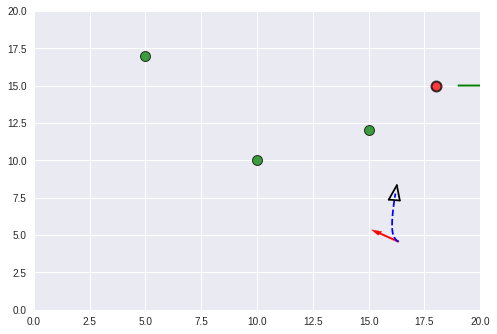

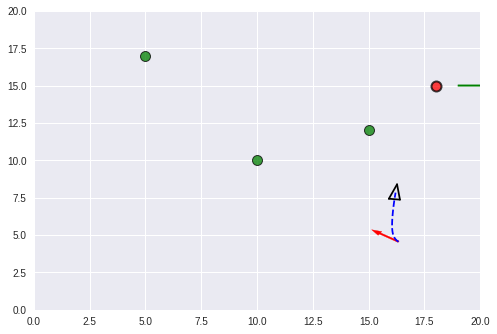

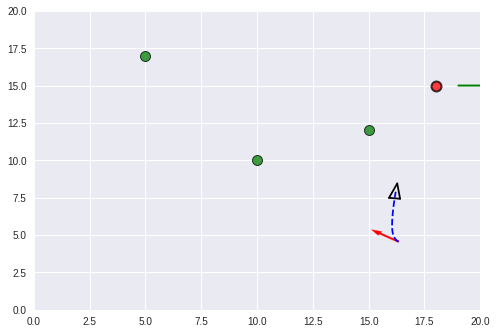

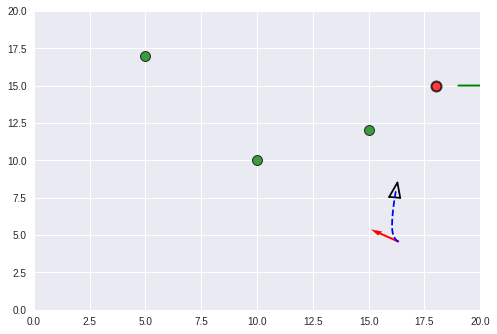

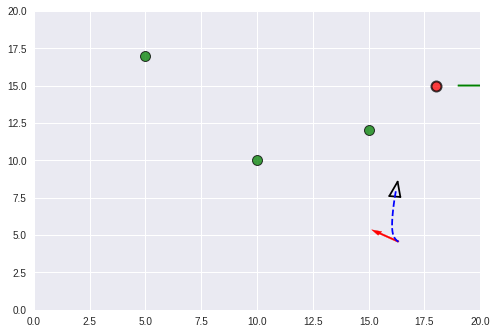

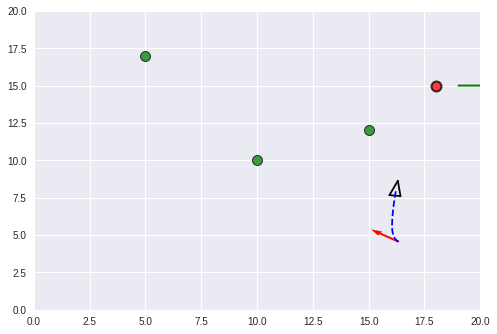

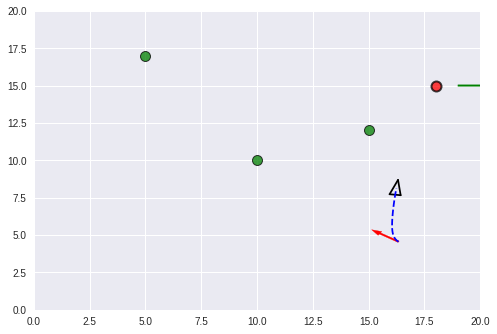

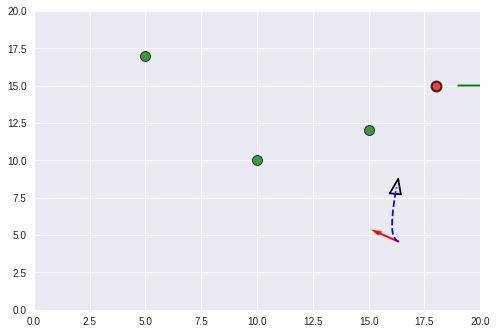

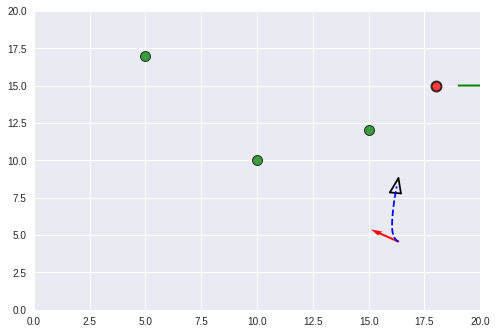

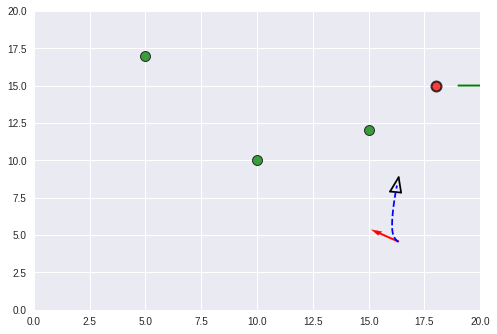

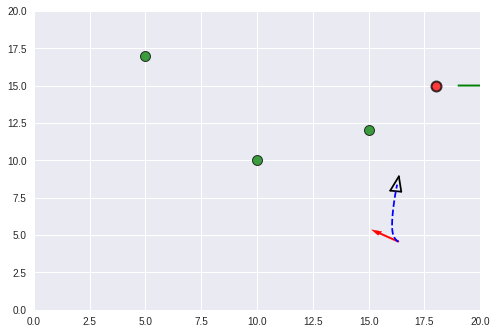

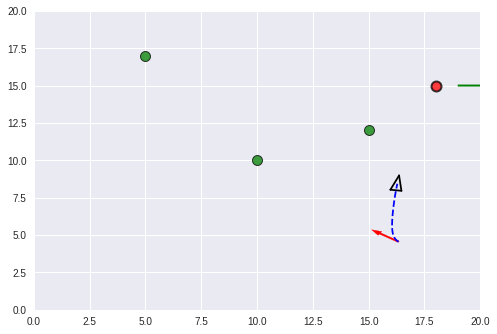

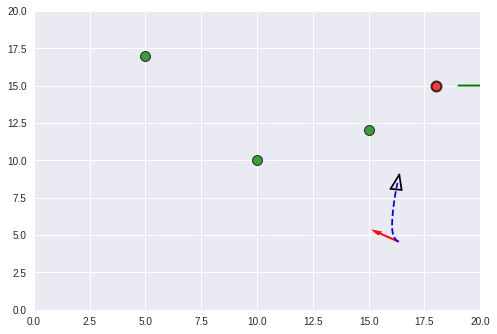

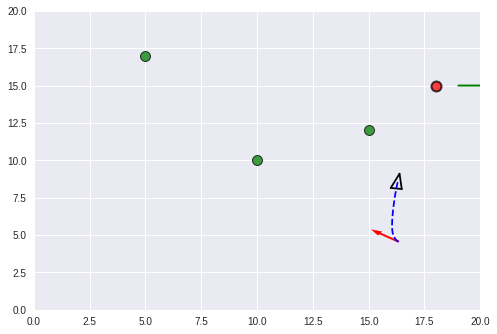

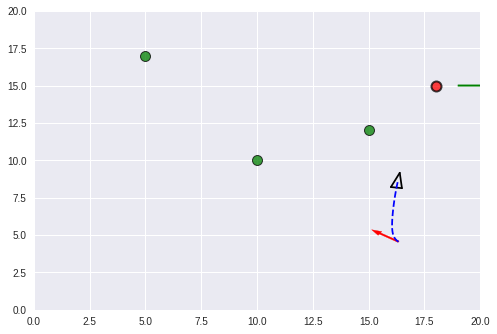

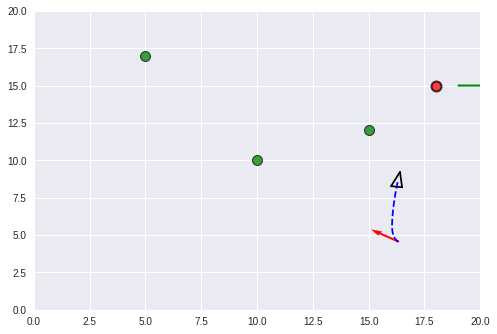

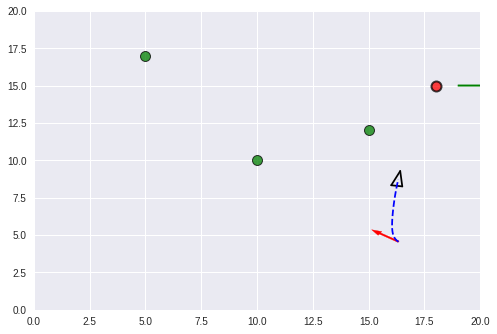

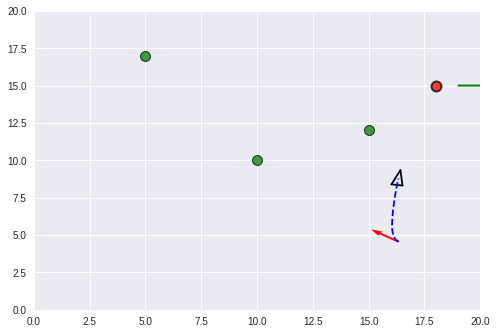

KeyboardInterrupt: ignored

<Figure size 576x396 with 0 Axes>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from random import random

# simulation parameters
Kp_rho = 9
Kp_alpha = 15
Kp_beta = -3
dt = 0.01

show_animation = True


def move_to_pose(x_start, y_start, theta_start, x_goal, y_goal, theta_goal):
    """
    rho is the distance between the robot and the goal position
    alpha is the angle to the goal relative to the heading of the robot
    beta is the angle between the robot's position and the goal position plus the goal angle
    Kp_rho*rho and Kp_alpha*alpha drive the robot along a line towards the goal
    Kp_beta*beta rotates the line so that it is parallel to the goal angle
    """
    x = x_start
    y = y_start
    theta = theta_start

    x_diff = x_goal - x
    y_diff = y_goal - y

    x_traj, y_traj = [], []

    rho = np.hypot(x_diff, y_diff)
    while rho > 0.001:
        x_traj.append(x)
        y_traj.append(y)

        x_diff = x_goal - x
        y_diff = y_goal - y

        # Restrict alpha and beta (angle differences) to the range
        # [-pi, pi] to prevent unstable behavior e.g. difference going
        # from 0 rad to 2*pi rad with slight turn

        rho = np.hypot(x_diff, y_diff) # calculates hypotenuse of x_diff and y_diff. ## reward is also a function of rho 
        alpha = (np.arctan2(y_diff, x_diff) 
                    - theta + np.pi) % (2 * np.pi) - np.pi ## approximated by nn , reward is a function of true value of alpha 
        #alpha=0.1
        #beta=0.2     
        beta = (theta_goal - theta - alpha + np.pi) % (2 * np.pi) - np.pi ## approximated by nn , reward is a function of true value of beta 

        v = Kp_rho * rho
        w = Kp_alpha * alpha + Kp_beta * beta

        if alpha > np.pi / 2 or alpha < -np.pi / 2:
            v = -v

        theta = theta + w * dt
        x = x + 6 * np.cos(theta) * dt
        y = y + 6 * np.sin(theta) * dt

        if show_animation:  # pragma: no cover
            plt.cla()
            plt.arrow(x_start, y_start, np.cos(theta_start),
                      np.sin(theta_start), color='r', width=0.1)
            plt.arrow(x_goal, y_goal, np.cos(theta_goal),
                      np.sin(theta_goal), color='g', width=0.1)
            plot_vehicle(x, y, theta, x_traj, y_traj)


def plot_vehicle(x, y, theta, x_traj, y_traj):  # pragma: no cover
    # Corners of triangular vehicle when pointing to the right (0 radians)
    p1_i = np.array([0.5, 0, 1]).T
    p2_i = np.array([-0.5, 0.25, 1]).T
    p3_i = np.array([-0.5, -0.25, 1]).T

    T = transformation_matrix(x, y, theta)
    p1 = np.matmul(T, p1_i)
    p2 = np.matmul(T, p2_i)
    p3 = np.matmul(T, p3_i)
    
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], 'k-')
    plt.plot([p2[0], p3[0]], [p2[1], p3[1]], 'k-')
    plt.plot([p3[0], p1[0]], [p3[1], p1[1]], 'k-')
    plt.style.use('seaborn')
    plt.scatter([5,10,15],[17,10,12],s=100,c='green',edgecolor='black',linewidth=1,alpha=0.75) 
    plt.style.use('seaborn')
    plt.scatter([18],[15],s=100,c='red',edgecolor='black',linewidth=2,alpha=0.75)   
    plt.plot(x_traj, y_traj, 'b--')
    #circle1 = plt.Circle((0, 0), 0.2, color='r')
    #fig, ax = plt.subplots()
    
    # for stopping simulation with the esc key.
    plt.gcf().canvas.mpl_connect('key_release_event',
            lambda event: [exit(0) if event.key == 'escape' else None])
    
    plt.xlim(0, 20)
    plt.ylim(0, 20)
    
    plt.pause(dt)


def transformation_matrix(x, y, theta):
    return np.array([
        [np.cos(theta), -np.sin(theta), x],
        [np.sin(theta), np.cos(theta), y],
        [0, 0, 1]
    ])


def main():

    for i in range(1):
        x_start = 20 * random()
        y_start = 20 * random()
        theta_start = 2 * np.pi * random() - np.pi
        x_goal = 19
        y_goal = 15
        theta_goal = 0 
        print("Initial x: %.2f m\nInitial y: %.2f m\nInitial theta: %.2f rad\n" %
              (x_start, y_start, theta_start))
        print("Goal x: %.2f m\nGoal y: %.2f m\nGoal theta: %.2f rad\n" %
              (x_goal, y_goal, theta_goal))
        move_to_pose(x_start, y_start, theta_start, x_goal, y_goal, theta_goal)


if __name__ == '__main__':
    main()

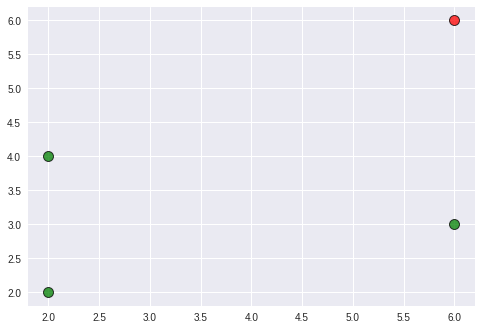

In [ ]:
plt.style.use('seaborn')
plt.scatter([2,3,6],[4,6,8],s=100,c='green',edgecolor='black',linewidth=1,alpha=0.75) 
plt.style.use('seaborn')
plt.scatter([20],[15],s=100,c='red',edgecolor='black',linewidth=1,alpha=0.75) 
